#### Import libraries

In [23]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
import neuprint
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_neurons, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix


Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[male-cns:v0.9].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



# Fetch connections

In [24]:
n0, _ = fetch_neurons(NC(type='^AOTU.*'))

In [25]:
# Get unique instances of AOTU neurons
inst = n0['instance'].unique()

In [26]:
# Art
# #  Set connection weight threshold
threshold = 5 #minimum 5 synapses

# Fetch synaptic connectivity between pre and post types
neu_df, conn_df = fetch_adjacencies(sources=NC(instance=inst), targets=NC(instance=inst), min_roi_weight=threshold)

# Merge with neuron properties to get types on both sides
conn_all_df = merge_neuron_properties(neu_df, conn_df)

# Group by type combinations and sum the weights by type
conn_inst = conn_all_df.groupby(['instance_pre','instance_post'])['weight'].sum().reset_index()

# Visualize
#conn_all_df_type

  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
# Art
# # group by instance and sum the upstream values
wt_upstream = n0.groupby('instance').agg({'upstream': 'sum'}).reset_index()

In [29]:
# Art
# # match instance in wt_upstream to instance_post in conn_inst, then divide the weight in conn_inst by the upstream value
conn_inst = conn_inst.merge(wt_upstream, left_on='instance_post', right_on='instance', suffixes=('', '_upstream'))
conn_inst['wt_norm'] = conn_inst['weight'] / conn_inst['upstream']
conn_inst = conn_inst.drop(columns=['instance', 'upstream'])    

In [30]:
conn_inst

,instance_pre,instance_post,weight,wt_norm
0,AOTU001_L,AOTU001_L,15,0.002622
1,AOTU001_L,AOTU033_R,6,0.000874
2,AOTU001_L,AOTU042_R,8,0.000390
3,AOTU001_R,AOTU019_L,5,0.000163
4,AOTU001_R,AOTU042_L,41,0.001900
...,...,...,...,...
1405,AOTU103m_R,AOTU035_R,64,0.008481
1406,AOTU103m_R,AOTU037_R,5,0.002778
1407,AOTU103m_R,AOTU042_R,11,0.000536
1408,AOTU103m_R,AOTU056_R,5,0.001801


In [31]:
# Art
conn_inst.head(3)

,instance_pre,instance_post,weight,wt_norm
0,AOTU001_L,AOTU001_L,15,0.002622
1,AOTU001_L,AOTU033_R,6,0.000874
2,AOTU001_L,AOTU042_R,8,0.000390


# Create the connectivity matrix

## Raw_all

In [32]:
# Create matrix of connection weights: instance_pre to instance_post 
matrix_df = conn_inst.pivot_table(index='instance_pre', columns='instance_post', values='weight', aggfunc='sum', fill_value=0)

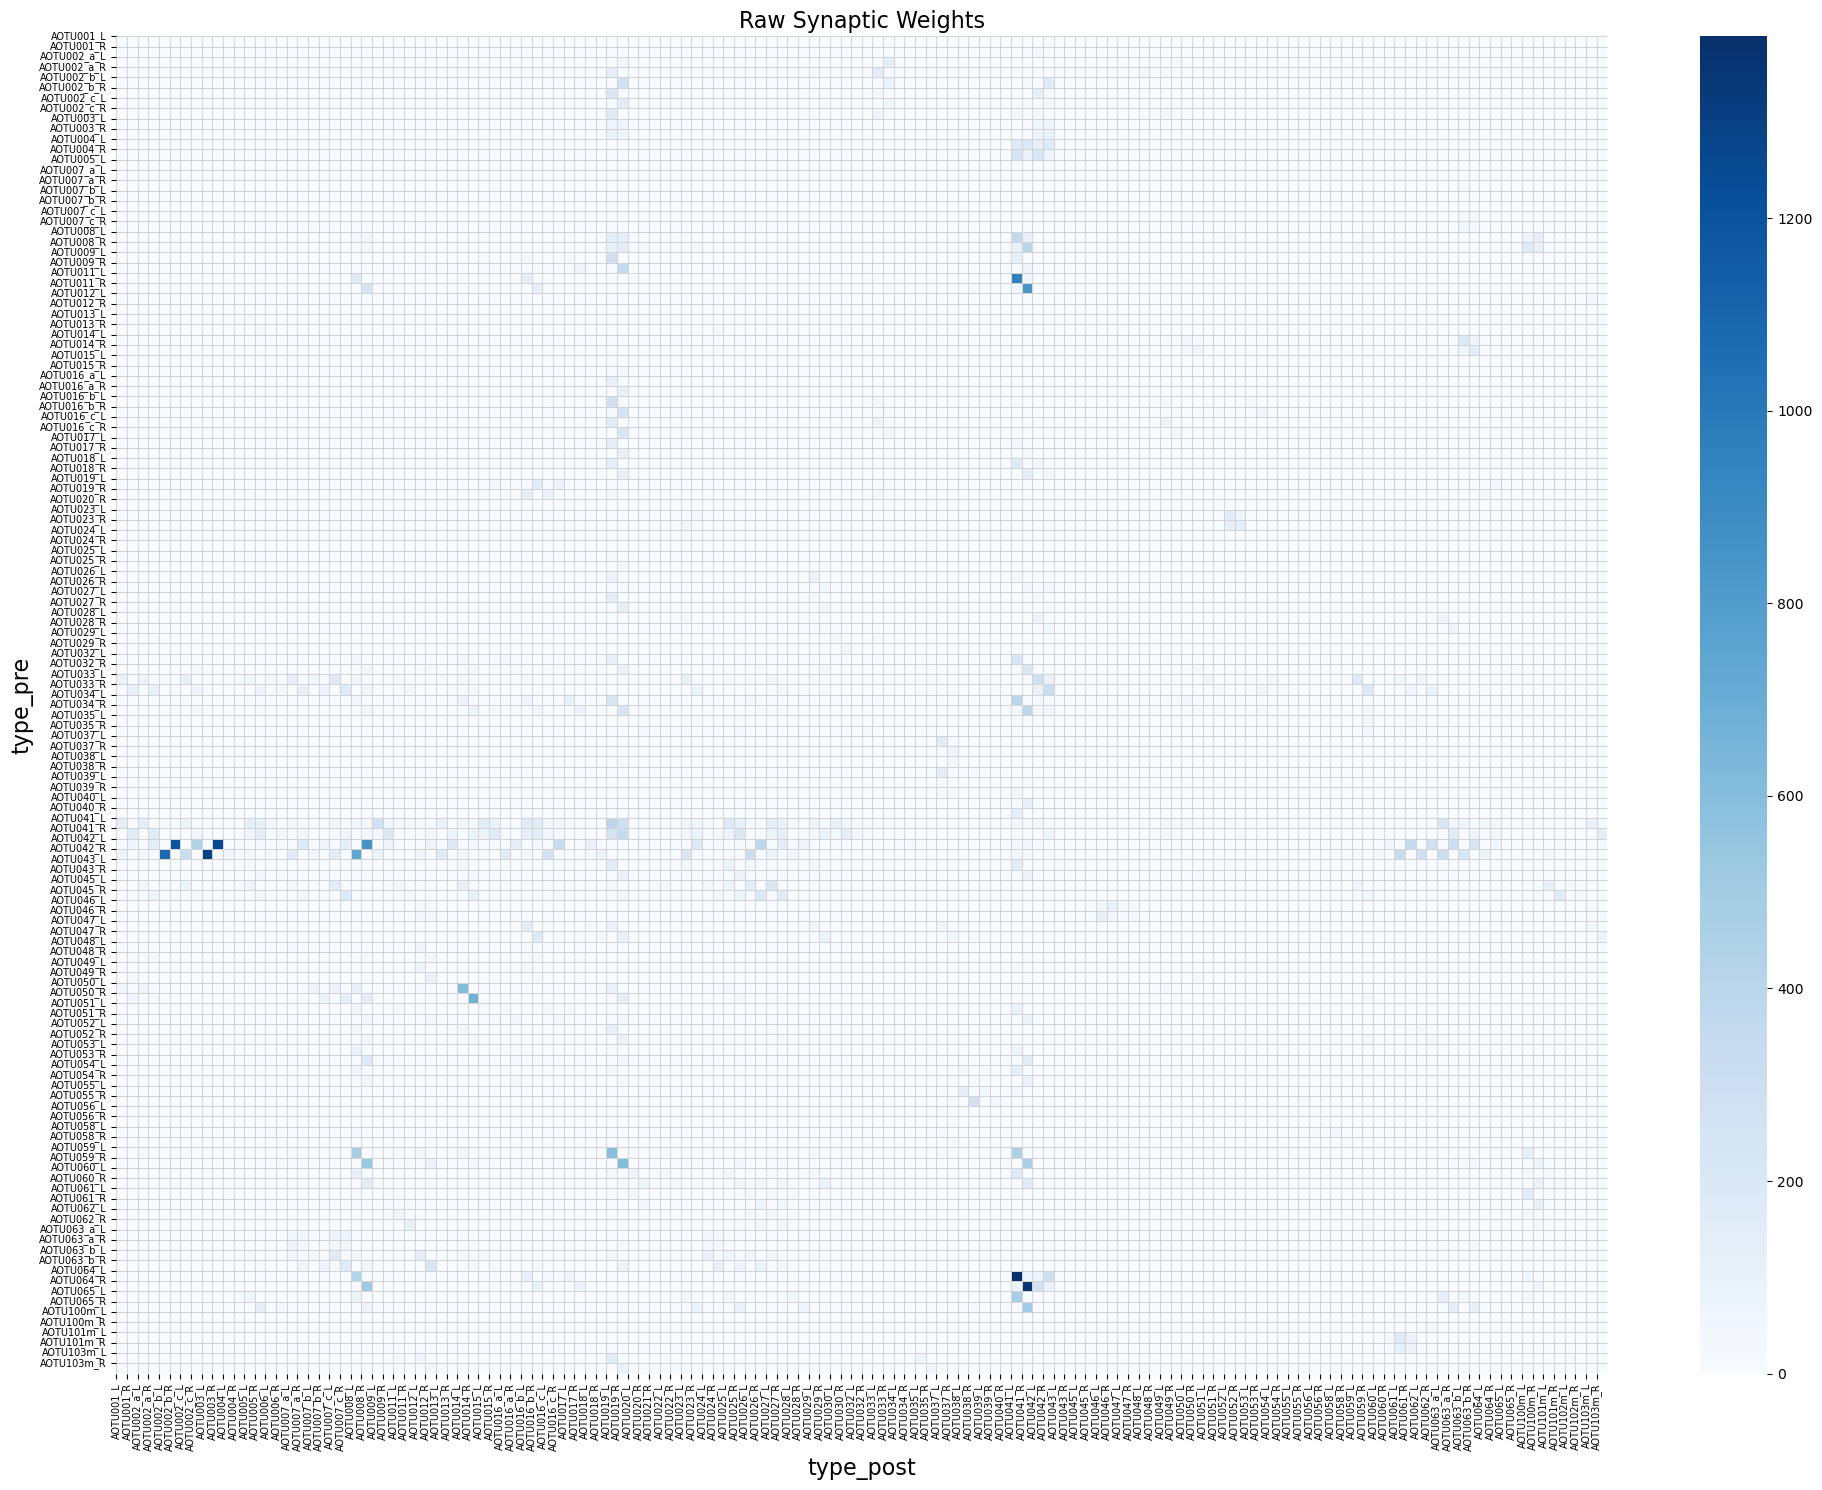

In [33]:
plt.figure(figsize=(20, 15))
ax = sb.heatmap(matrix_df, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray')

ax.set_title('Raw Synaptic Weights', fontsize = 16)
ax.set_xlabel('type_post', fontsize = 16)
ax.set_ylabel('type_pre', fontsize = 16)

ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
os.makedirs('results/AOTU', exist_ok=True)
plt.savefig('results/AOTU/Raw synaptic weights_AOTU_AOTU_all.png', dpi=600)

plt.show()

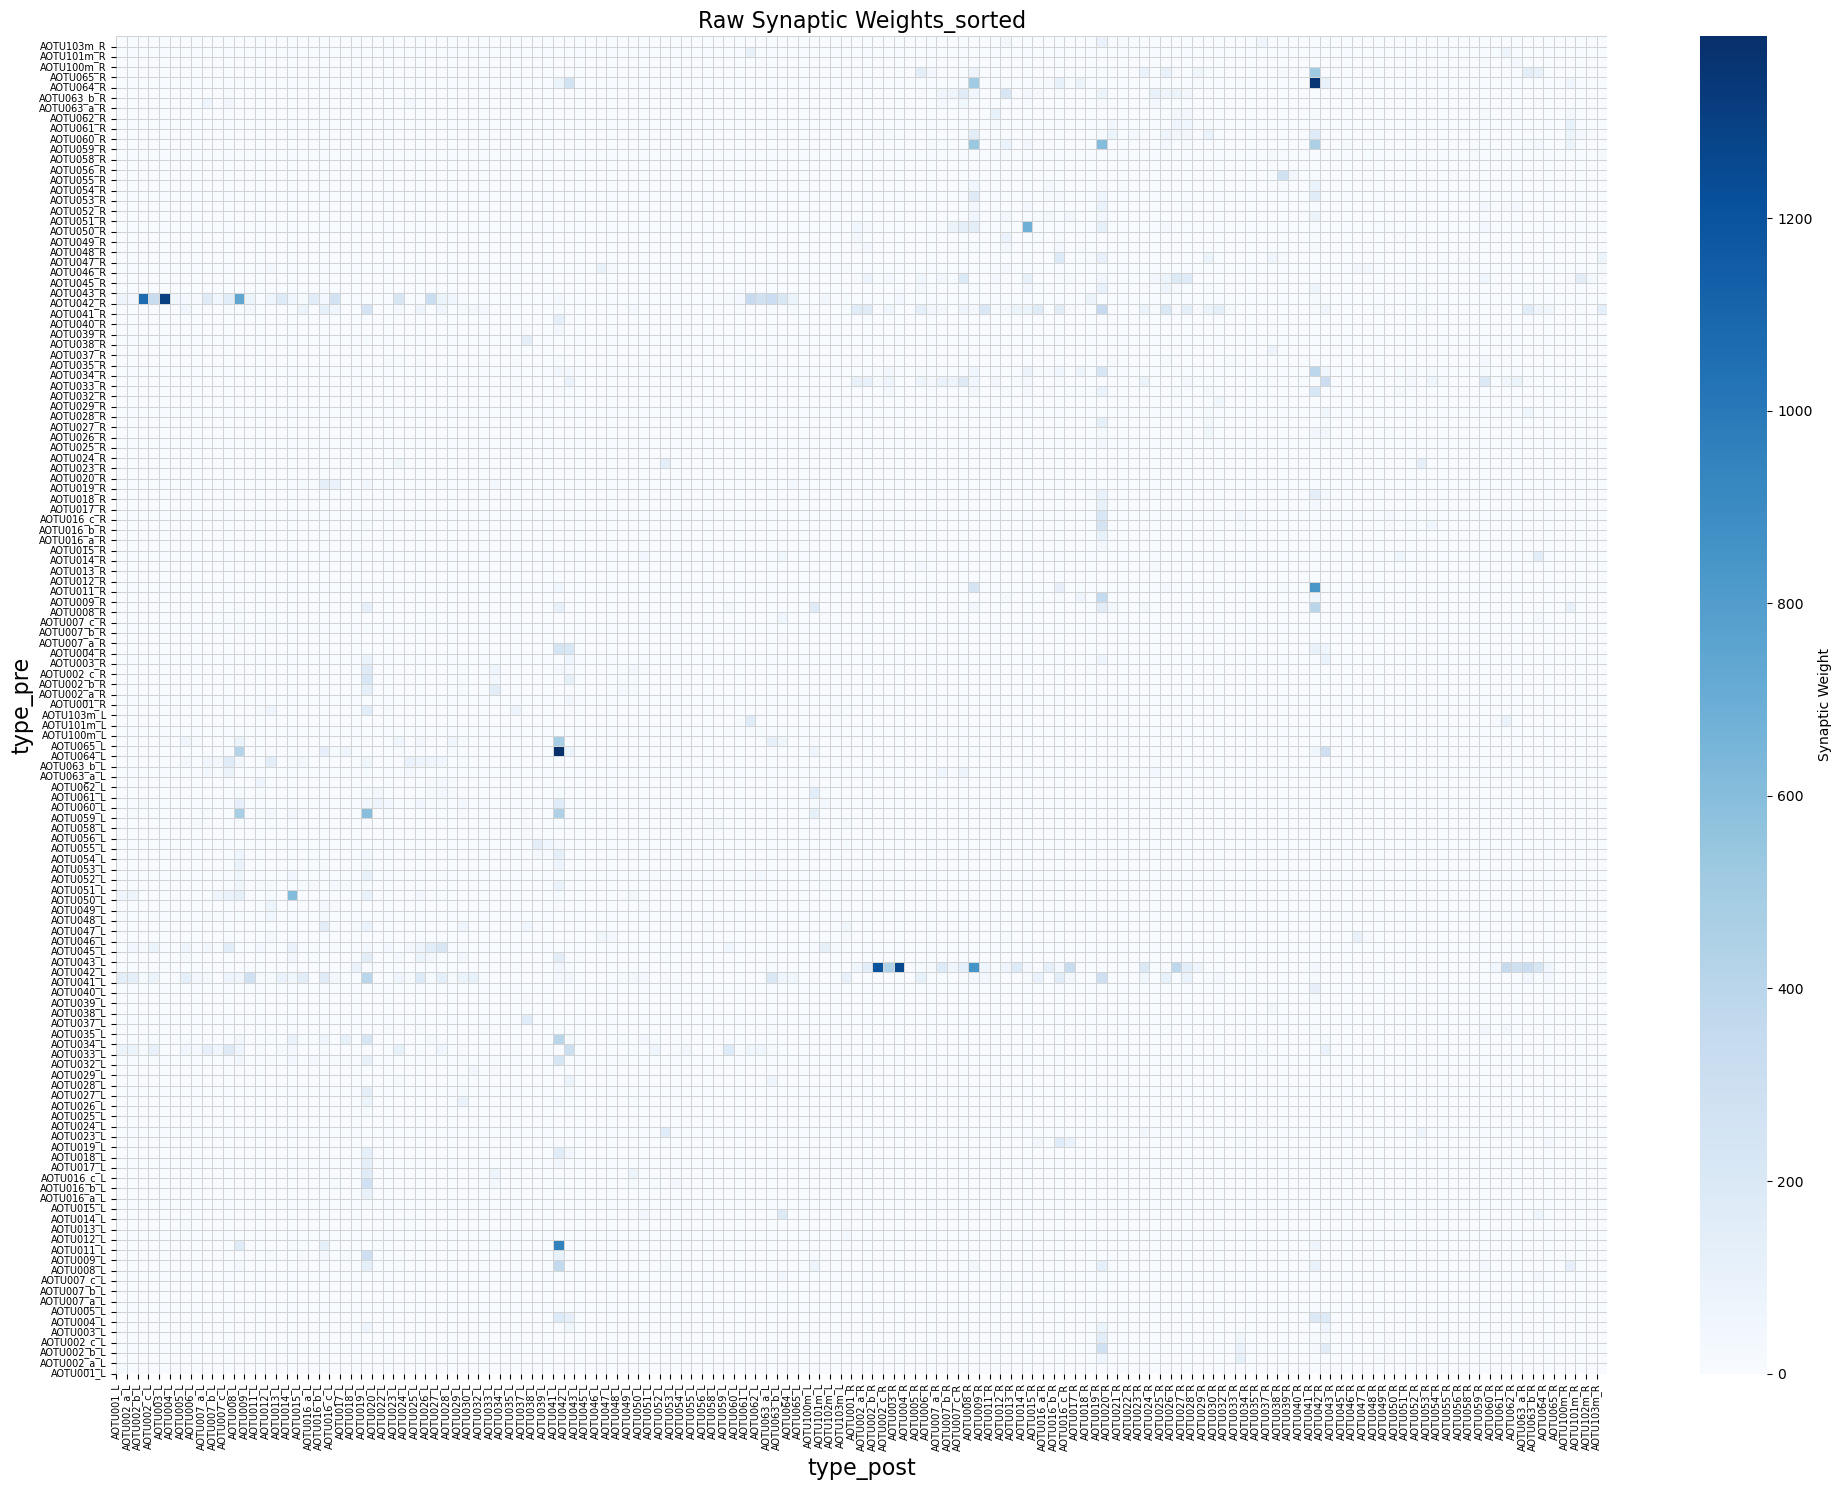

In [34]:
## Sorted heat map

import re
# Inline sorting using lambda
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and(m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)  # fallback if no match

# Get sorted row and column order
sorted_rows = sorted(matrix_df.index, key=sort_key)
sorted_cols = sorted(matrix_df.columns, key=sort_key)

# Reorder the matrix
ordered_matrix = matrix_df.loc[sorted_rows, sorted_cols]

plt.figure(figsize=(20, 15))
ax = sb.heatmap(ordered_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray', cbar_kws={"label": "Synaptic Weight"})

ax.set_title('Raw Synaptic Weights_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_matrix.index)))
ax.set_yticklabels(ordered_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_matrix.columns)))
ax.set_xticklabels(ordered_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

plt.savefig('results/AOTU/Raw synaptic weights_AOTU_AOTU_all_sorted.png', dpi=600)
plt.show()


### Top n inputs raw

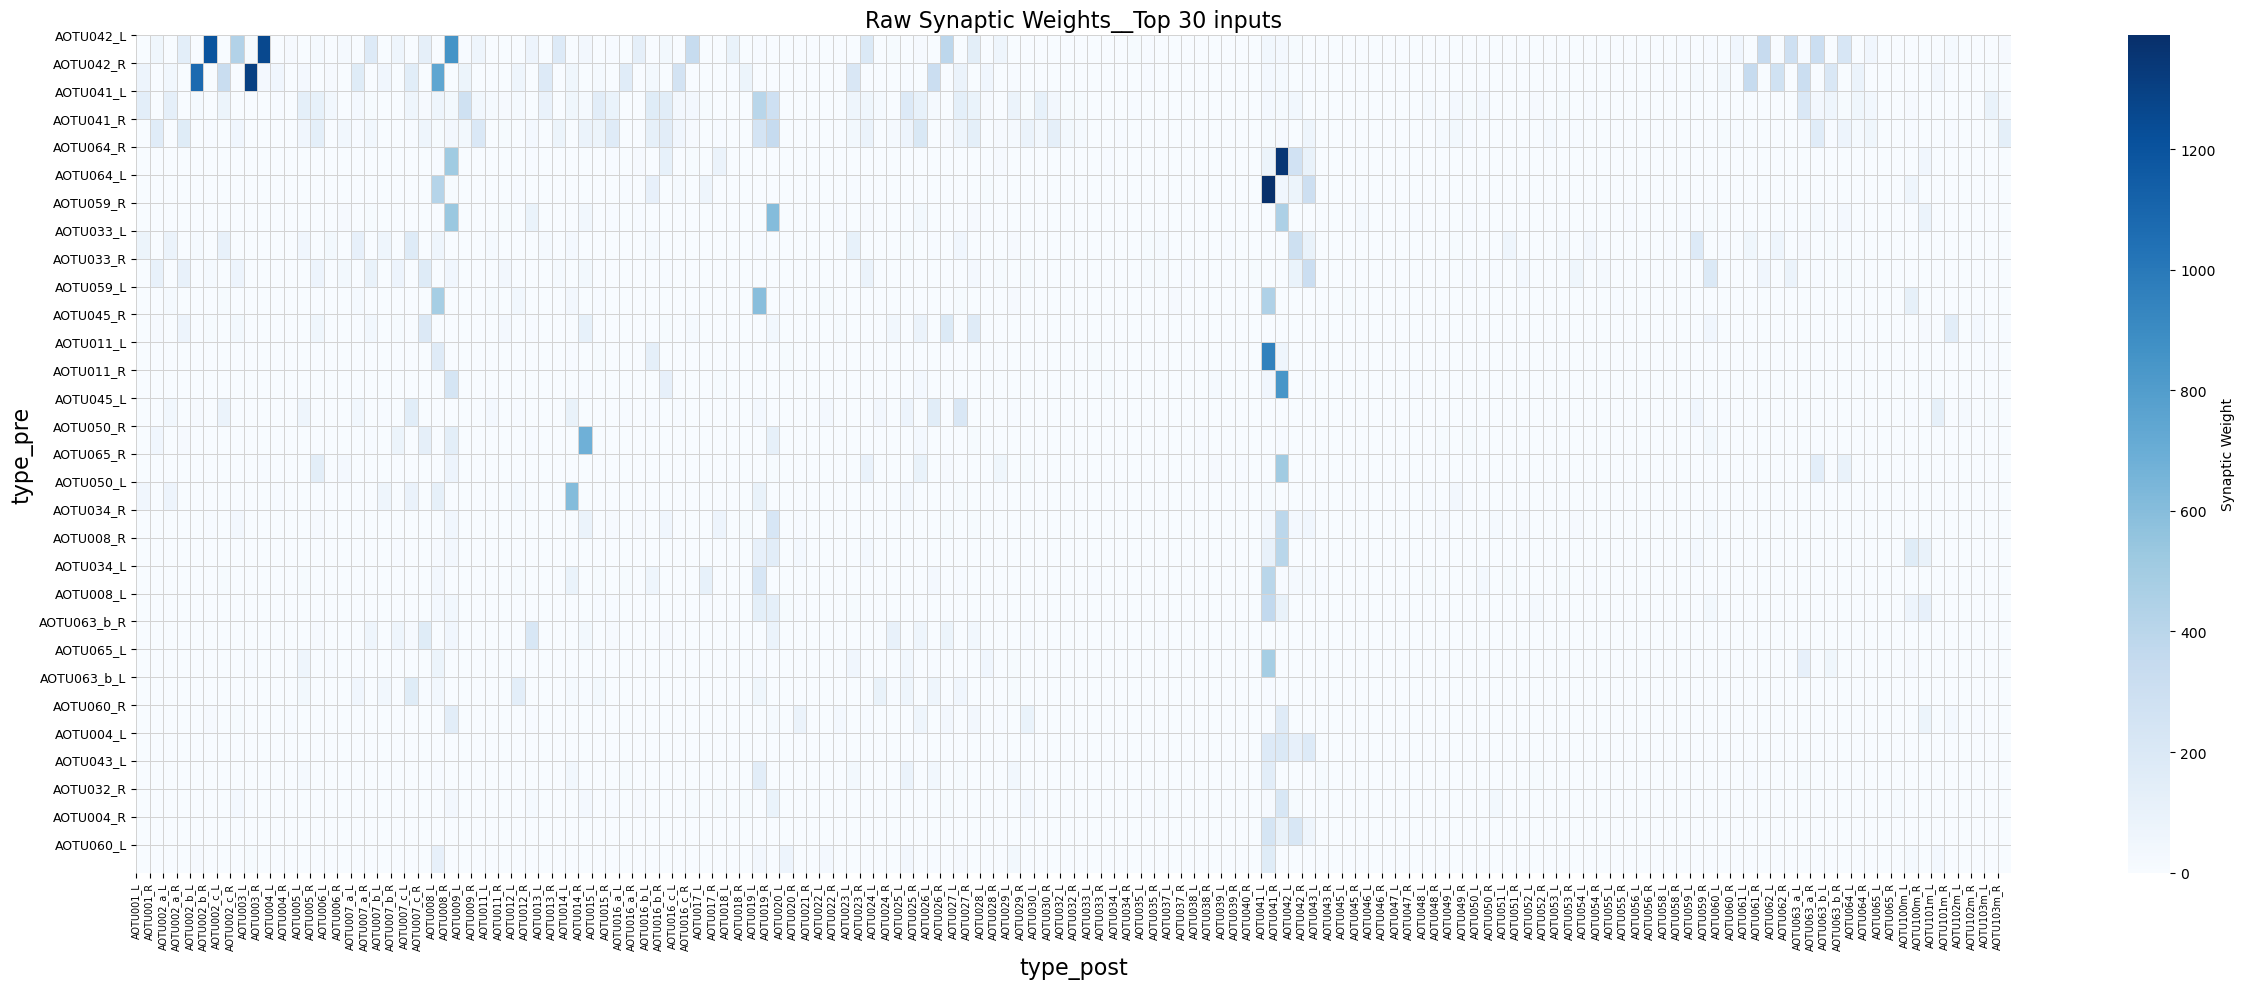

In [171]:
# top n inputs raw
n = 30

# Find top n AOTU types by total outgoing weight to DNs
top_inputs_raw = matrix_df.sum(axis=1).nlargest(n).index

# Slice submatrix for these AOTU pre types
top_input_matrix = matrix_df.loc[top_inputs_raw]

# Plot
plt.figure(figsize=(25, 10))
ax = sb.heatmap(top_input_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} inputs', fontsize = 16)
ax.set_xlabel('type_post', fontsize = 16)
ax.set_ylabel('type_pre', fontsize = 16)

ax.set_yticks(range(len(top_input_matrix.index)))
ax.set_yticklabels(top_input_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_matrix.columns)))
ax.set_xticklabels(top_input_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
plt.savefig('results/AOTU/Raw synaptic weights_AOTU_AOTU_top30inputs.png', dpi=600)

plt.show()

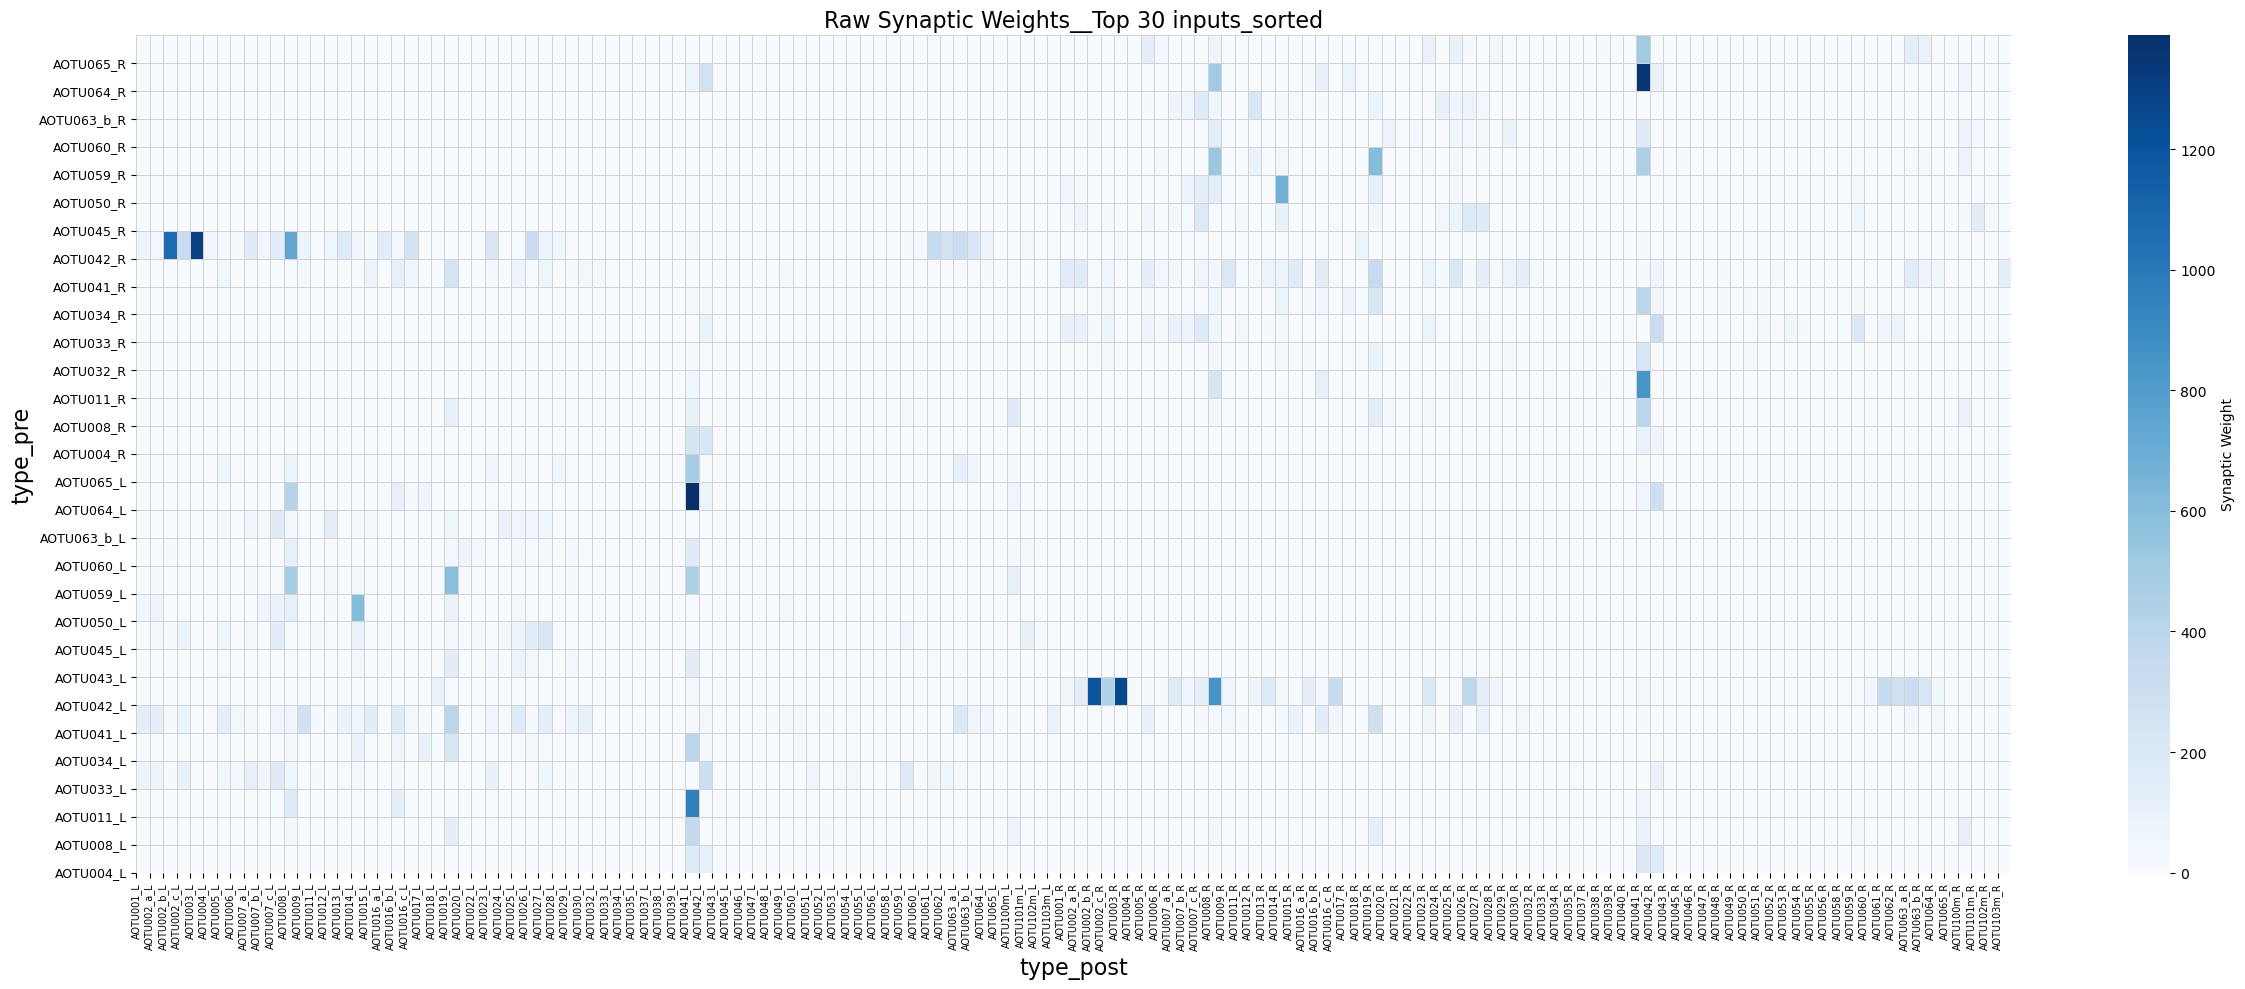

In [172]:
## Sorted heat map
n = 30

# Get top N AOTU instances by total output (rows)
top_inputs_raw = matrix_df.sum(axis=1).nlargest(n).index
top_input_matrix = matrix_df.loc[top_inputs_raw]

# Inline sort key (group by L/R, then ID, then subtype)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Apply sort to both rows and columns
sorted_rows = sorted(top_input_matrix.index, key=sort_key)
sorted_cols = sorted(top_input_matrix.columns, key=sort_key)

# Reorder matrix
ordered_top_input_matrix = top_input_matrix.loc[sorted_rows, sorted_cols]

# Plot
plt.figure(figsize=(25, 10))
ax = sb.heatmap(ordered_top_input_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} inputs_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_input_matrix.index)))
ax.set_yticklabels(ordered_top_input_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(ordered_top_input_matrix.columns)))
ax.set_xticklabels(ordered_top_input_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save figure
plt.savefig(f'results/AOTU/Raw synaptic weights_AOTU_AOTU_top30inputs_sorted', dpi=600)
plt.show()


### Top n outputs raw

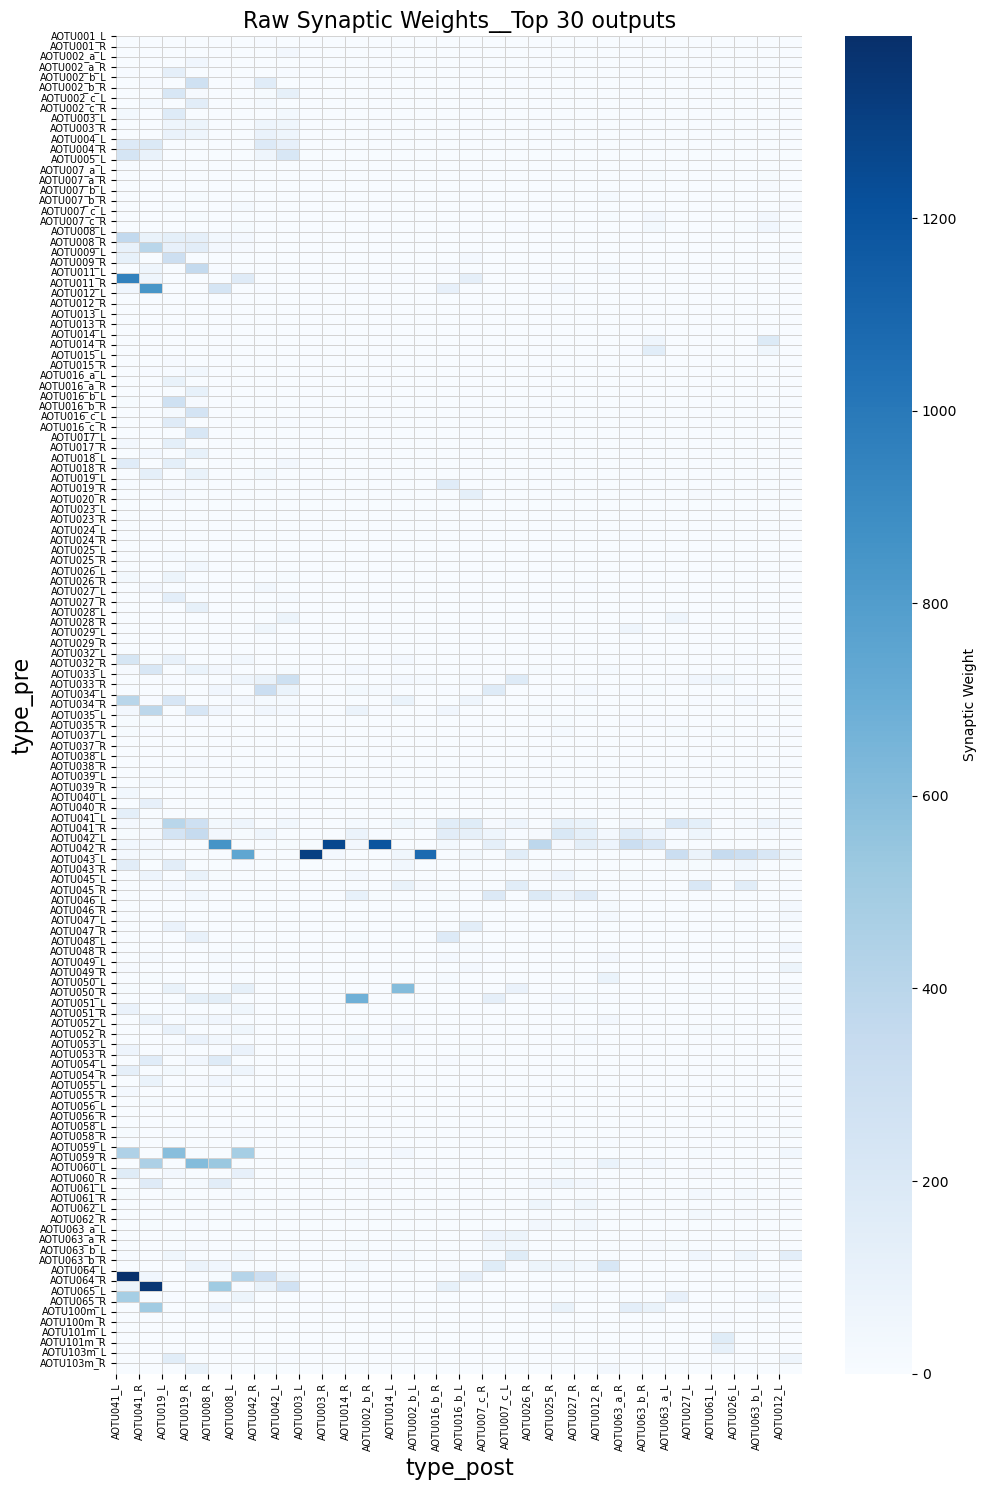

In [174]:
n = 30
# Top 30 posts (columns) by total input received
top_output_instances = matrix_df.sum(axis=0).nlargest(n).index
# Slice matrix: all pre, top 30 post
top_post_matrix = matrix_df.loc[:, top_output_instances]

# Plot
plt.figure(figsize=(10, 15))
ax = sb.heatmap(top_post_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} outputs', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(top_post_matrix.index)))
ax.set_yticklabels(top_post_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(top_post_matrix.columns)))
ax.set_xticklabels(top_post_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save figure
plt.savefig(f'results/AOTU/Raw synaptic weights_AOTU_AOTU_top30outputs.png', dpi=600)
plt.show()


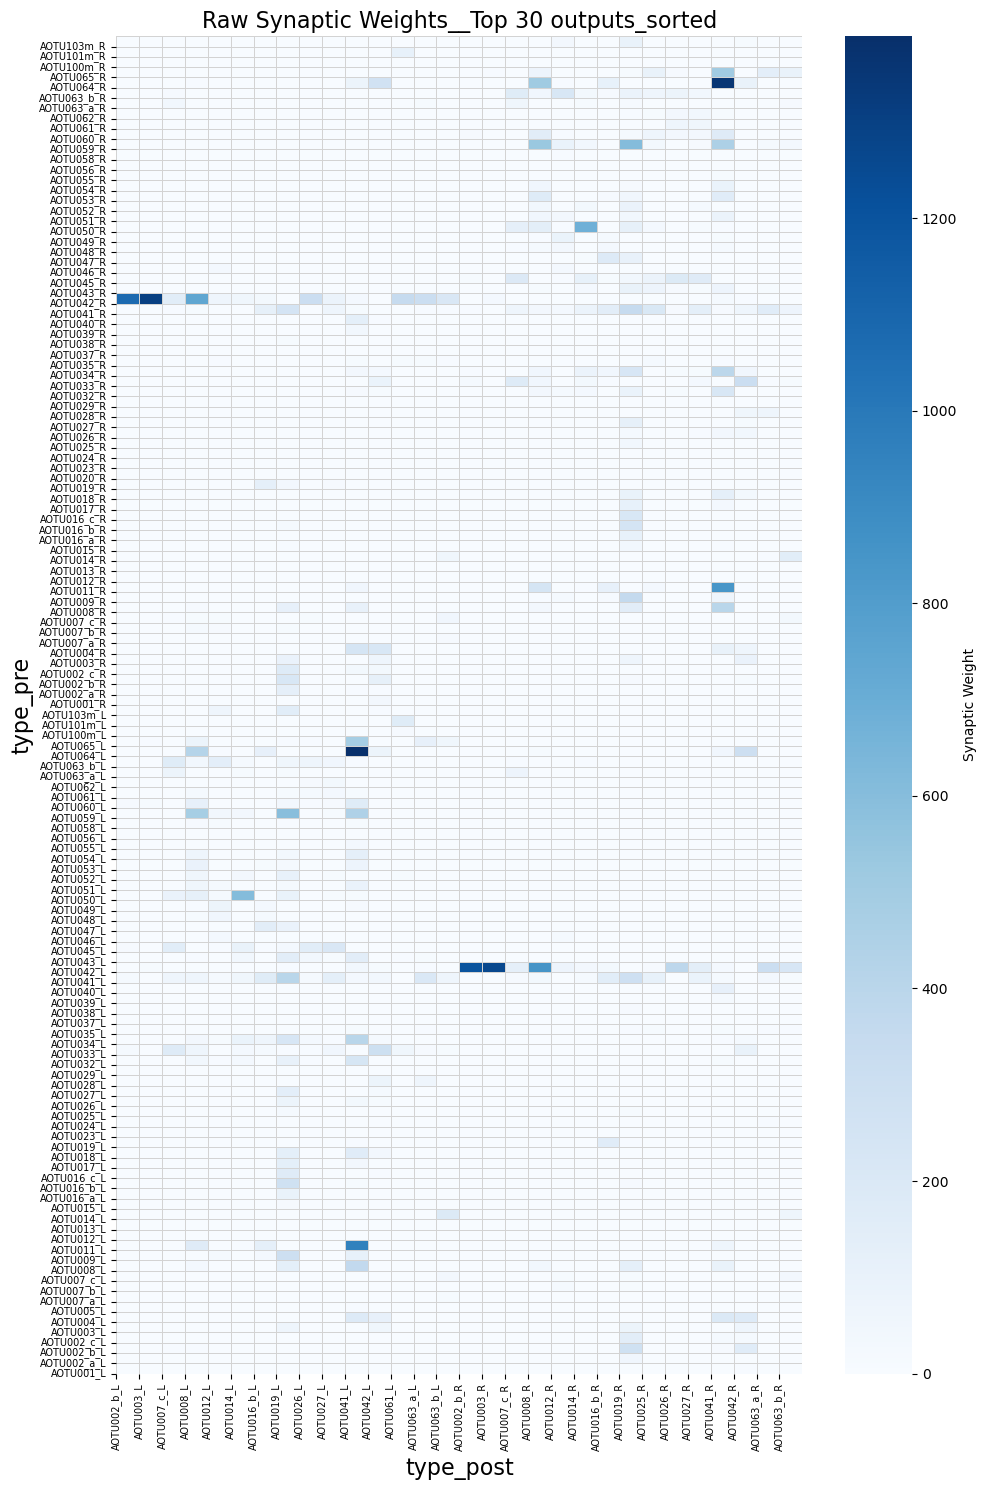

In [176]:
## Sorted heat map 

n = 30
# Step 1: Select top N post instances by total received weight
top_output_instances = matrix_df.sum(axis=0).nlargest(n).index
# Step 2: Slice matrix to all pre rows, top N post columns
top_post_matrix = matrix_df.loc[:, top_output_instances]

# Step 3: Define inline sort key (L/R → ID → subtype)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Step 4: Apply sorting
sorted_rows = sorted(top_post_matrix.index, key=sort_key)
sorted_cols = sorted(top_post_matrix.columns, key=sort_key)

# Step 5: Reorder matrix
ordered_top_post_matrix = top_post_matrix.loc[sorted_rows, sorted_cols]

# Step 6: Plot
plt.figure(figsize=(10, 15))
ax = sb.heatmap(ordered_top_post_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} outputs_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_post_matrix.index)))
ax.set_yticklabels(ordered_top_post_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_top_post_matrix.columns)))
ax.set_xticklabels(ordered_top_post_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save file
plt.savefig(f'results/AOTU/Raw synaptic weights_AOTU_AOTU_top30outputs_sorted.png', dpi=600)

plt.show()


## Normalized all

In [35]:
# Create matrix of normalized weights
norm_matrix_df = conn_inst.pivot_table(index='instance_pre', columns='instance_post', values='wt_norm', aggfunc='sum', fill_value=0)

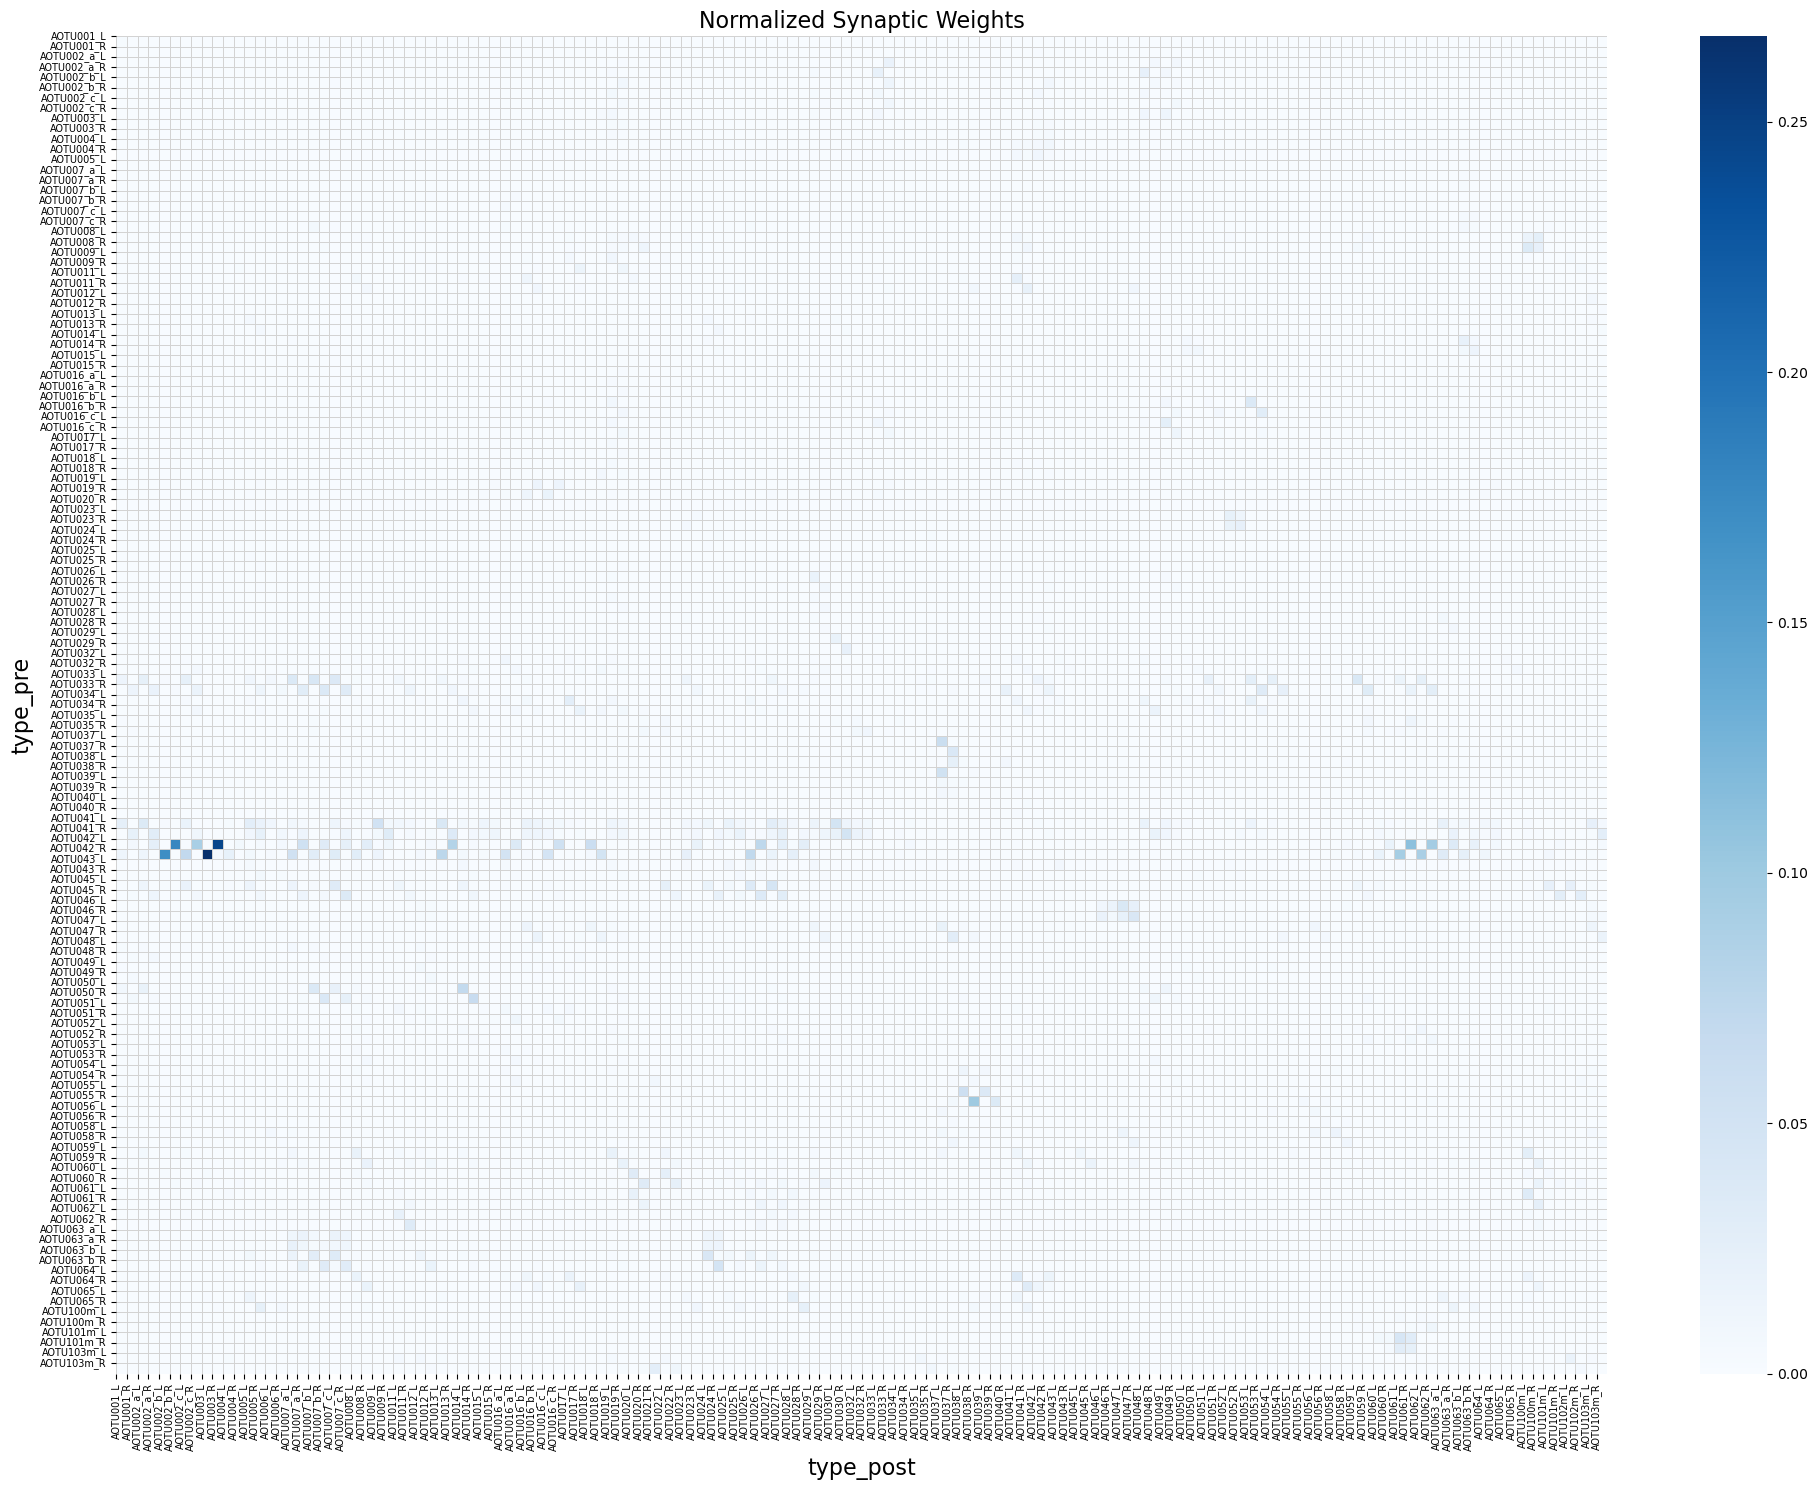

In [36]:
plt.figure(figsize=(20, 15))
ax = sb.heatmap(norm_matrix_df, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray')

ax.set_title('Normalized Synaptic Weights', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/AOTU/Normalized synaptic weights_AOTU_AOTU_all.png', dpi=600)

plt.show()

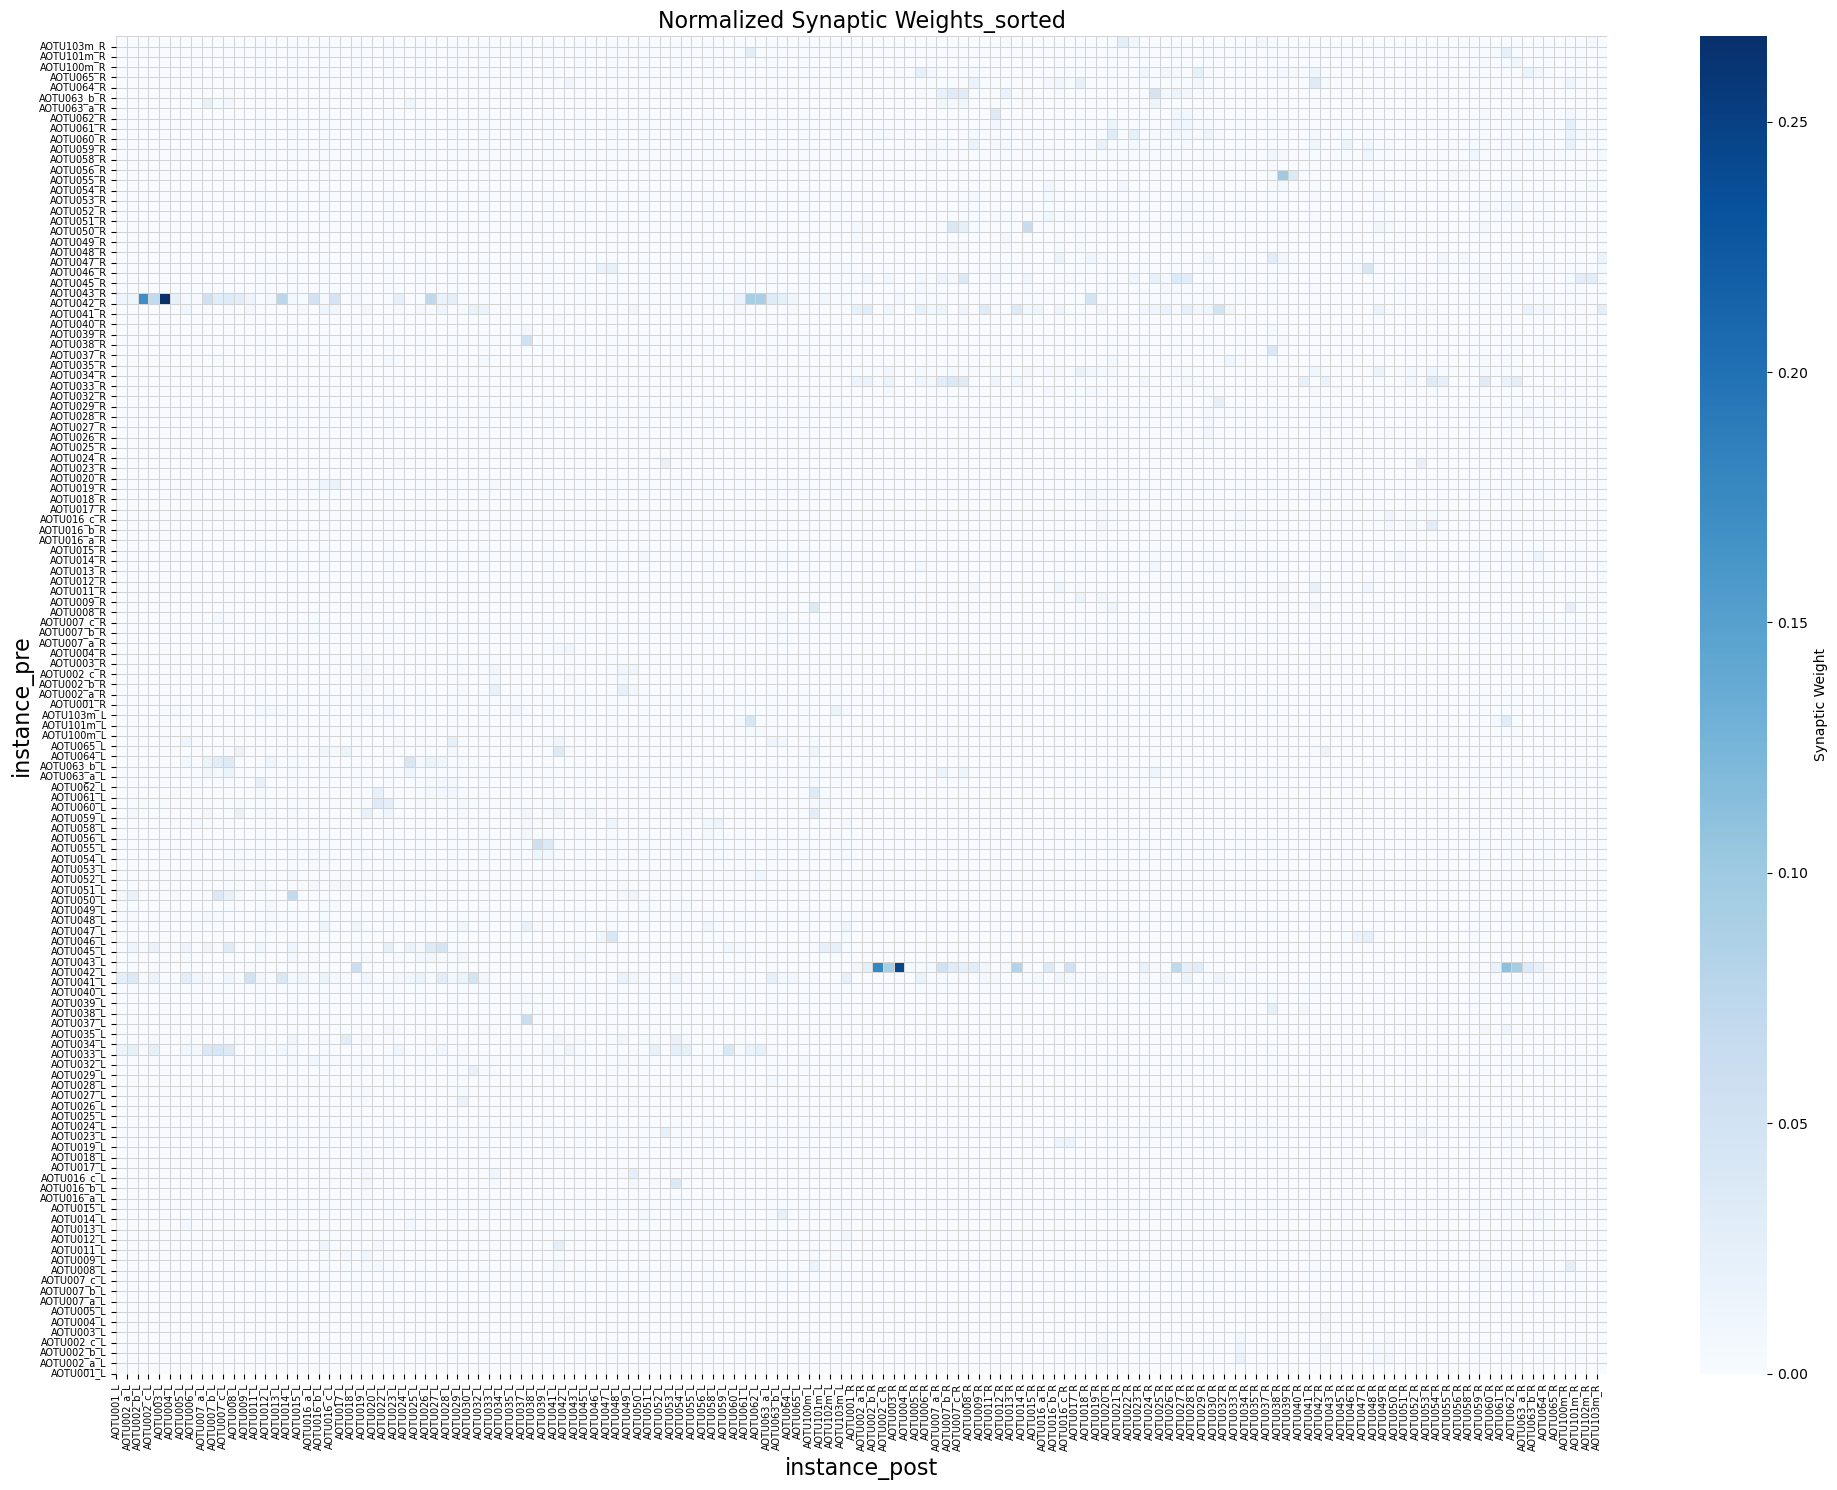

In [37]:

# Inline sorting using lambda
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and(m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)  # fallback if no match

# Get sorted row and column order
sorted_rows = sorted(norm_matrix_df.index, key=sort_key)
sorted_cols = sorted(norm_matrix_df.columns, key=sort_key)

# Reorder the matrix
ordered_matrix = norm_matrix_df.loc[sorted_rows, sorted_cols]

plt.figure(figsize=(20, 15))
ax = sb.heatmap(ordered_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray', cbar_kws={"label": "Synaptic Weight"})

ax.set_title('Normalized Synaptic Weights_sorted', fontsize=16)
ax.set_xlabel('instance_post', fontsize=16)
ax.set_ylabel('instance_pre', fontsize=16)

ax.set_yticks(range(len(ordered_matrix.index)))
ax.set_yticklabels(ordered_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_matrix.columns)))
ax.set_xticklabels(ordered_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()

plt.tight_layout()
plt.savefig('results/AOTU/Normalized synaptic weights_AOTU_AOTU_all_sorted.png', dpi=300)
plt.show()

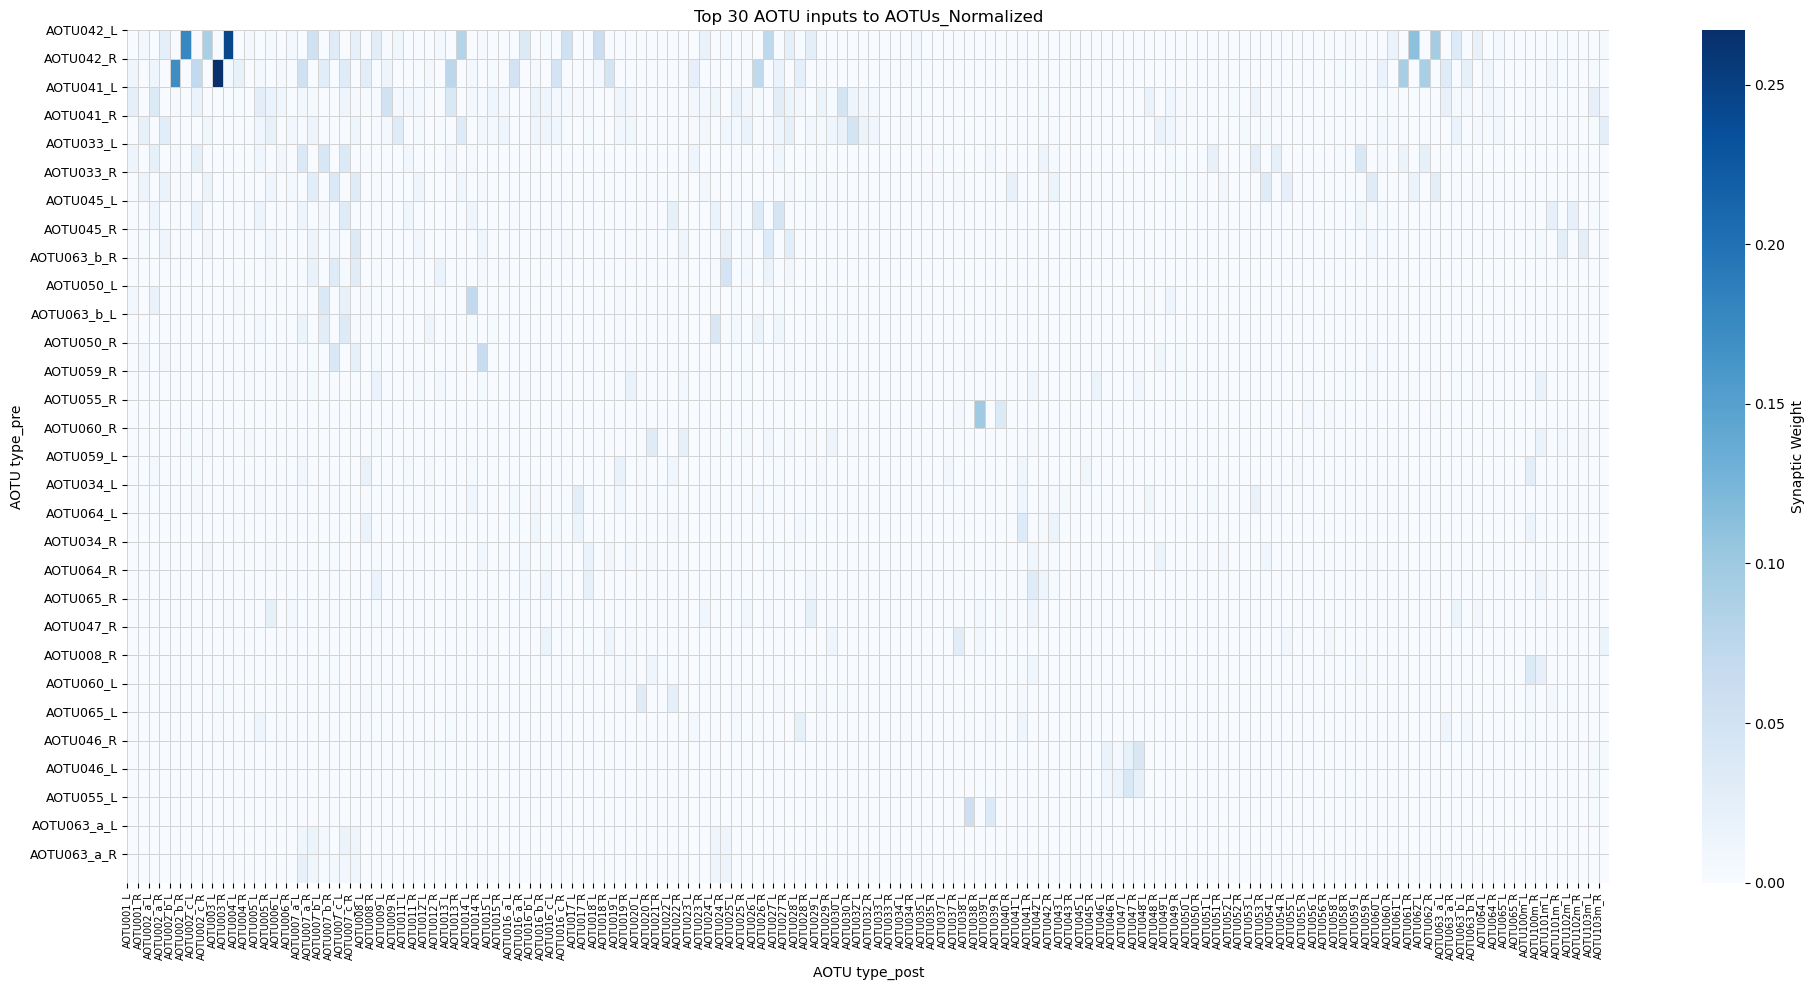

In [ ]:
n = 30
# Find top n AOTU types by total outgoing weight to DNs
top_inputs_norm = norm_matrix_df.sum(axis=1).nlargest(n).index

# Slice submatrix for these AOTU pre types
top_input_matrix_norm = norm_matrix_df.loc[top_inputs_norm]

# Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(top_input_matrix_norm, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} AOTU inputs to AOTUs_Normalized')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_input_matrix_norm.index)))
ax.set_yticklabels(top_input_matrix_norm.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_matrix_norm.columns)))
ax.set_xticklabels(top_input_matrix_norm.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/AOTU/Normalized synaptic weights_AOTU_AOTU_Top30inputs.png', dpi=300)

plt.show()

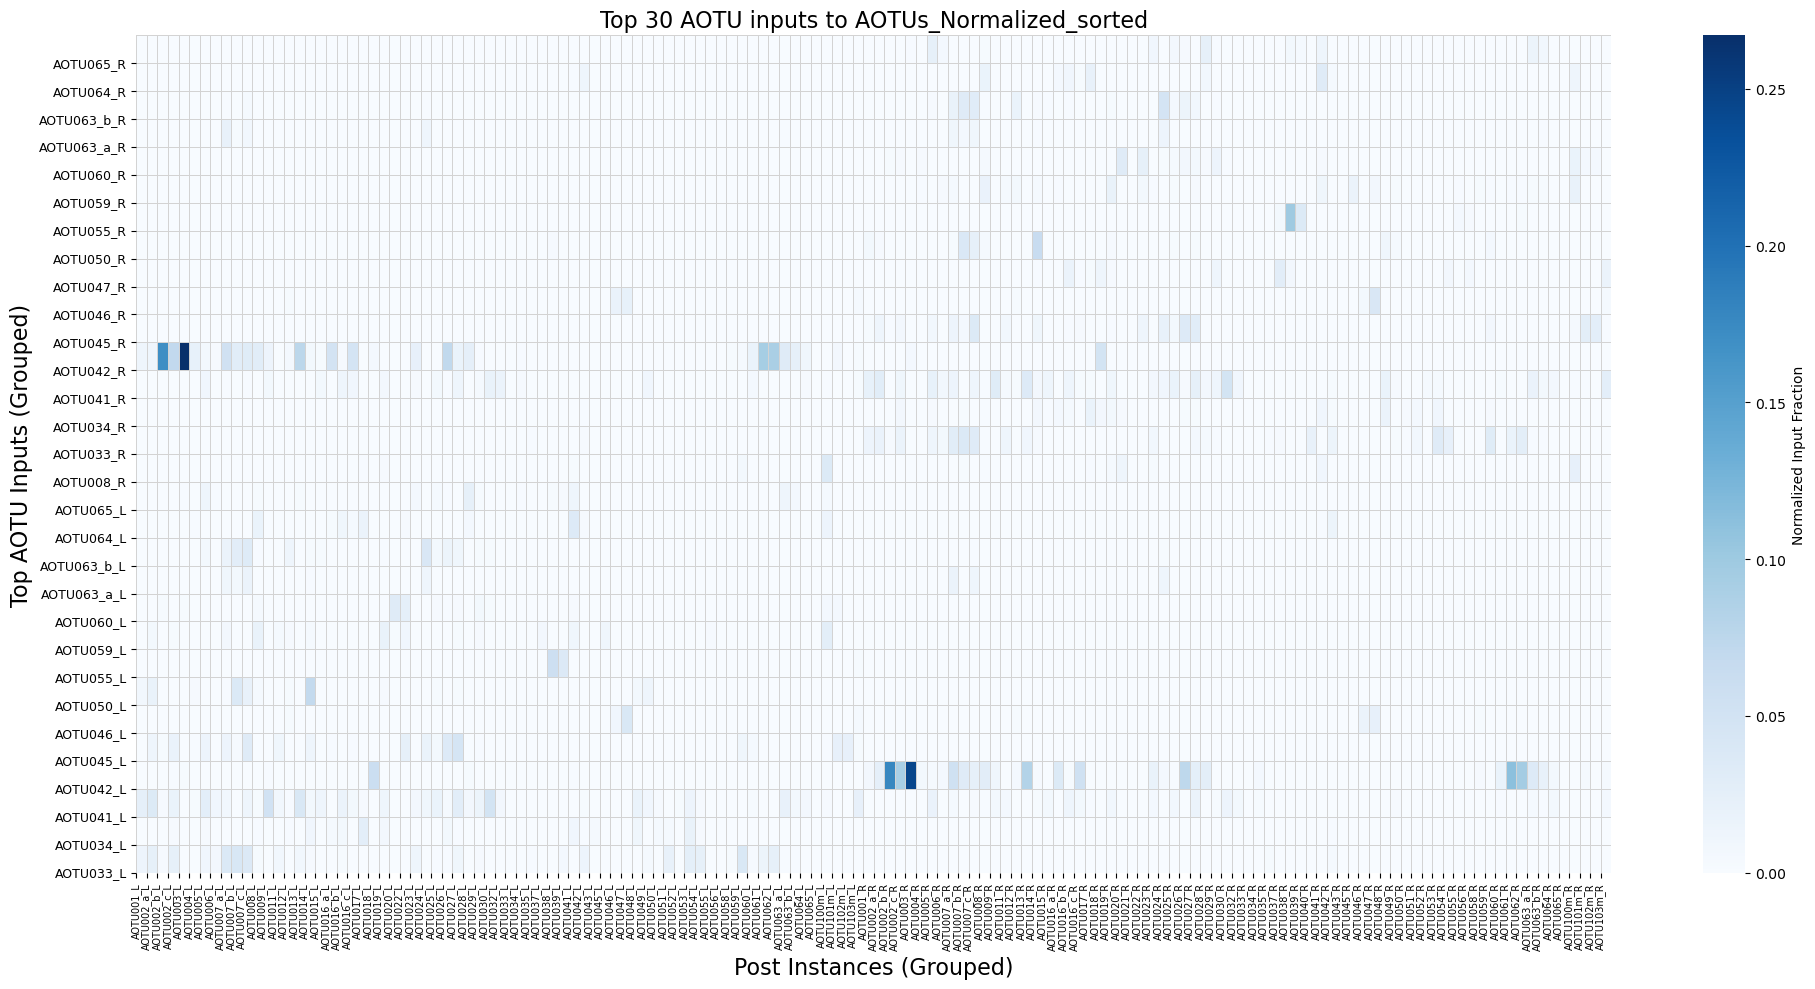

In [40]:
n = 30

# Step 1: Find top N AOTU types by total normalized output
top_inputs_norm = norm_matrix_df.sum(axis=1).nlargest(n).index
# Step 2: Slice normalized matrix by top N pre instances
top_input_matrix_norm = norm_matrix_df.loc[top_inputs_norm]

# Step 3: Define sorting key (inline)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Step 4: Sort rows and columns
sorted_rows = sorted(top_input_matrix_norm.index, key=sort_key)
sorted_cols = sorted(top_input_matrix_norm.columns, key=sort_key)

# Step 5: Reorder the matrix
ordered_top_input_matrix_norm = top_input_matrix_norm.loc[sorted_rows, sorted_cols]

# Step 6: Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(ordered_top_input_matrix_norm, cmap='Blues', annot=False, linewidths=0.5,
                linecolor='lightgray', cbar_kws={"label": "Normalized Input Fraction"})

ax.set_title(f'Top {n} AOTU inputs to AOTUs_Normalized_sorted', fontsize=16)
ax.set_xlabel('Post Instances (Grouped)', fontsize=16)
ax.set_ylabel('Top AOTU Inputs (Grouped)', fontsize=16)

ax.set_yticks(range(len(ordered_top_input_matrix_norm.index)))
ax.set_yticklabels(ordered_top_input_matrix_norm.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(ordered_top_input_matrix_norm.columns)))
ax.set_xticklabels(ordered_top_input_matrix_norm.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save
os.makedirs('results', exist_ok=True)
plt.savefig('results/AOTU/Normalized synaptic weights_AOTU_AOTU_Top30inputs_sorted.png', dpi=300)

plt.show()


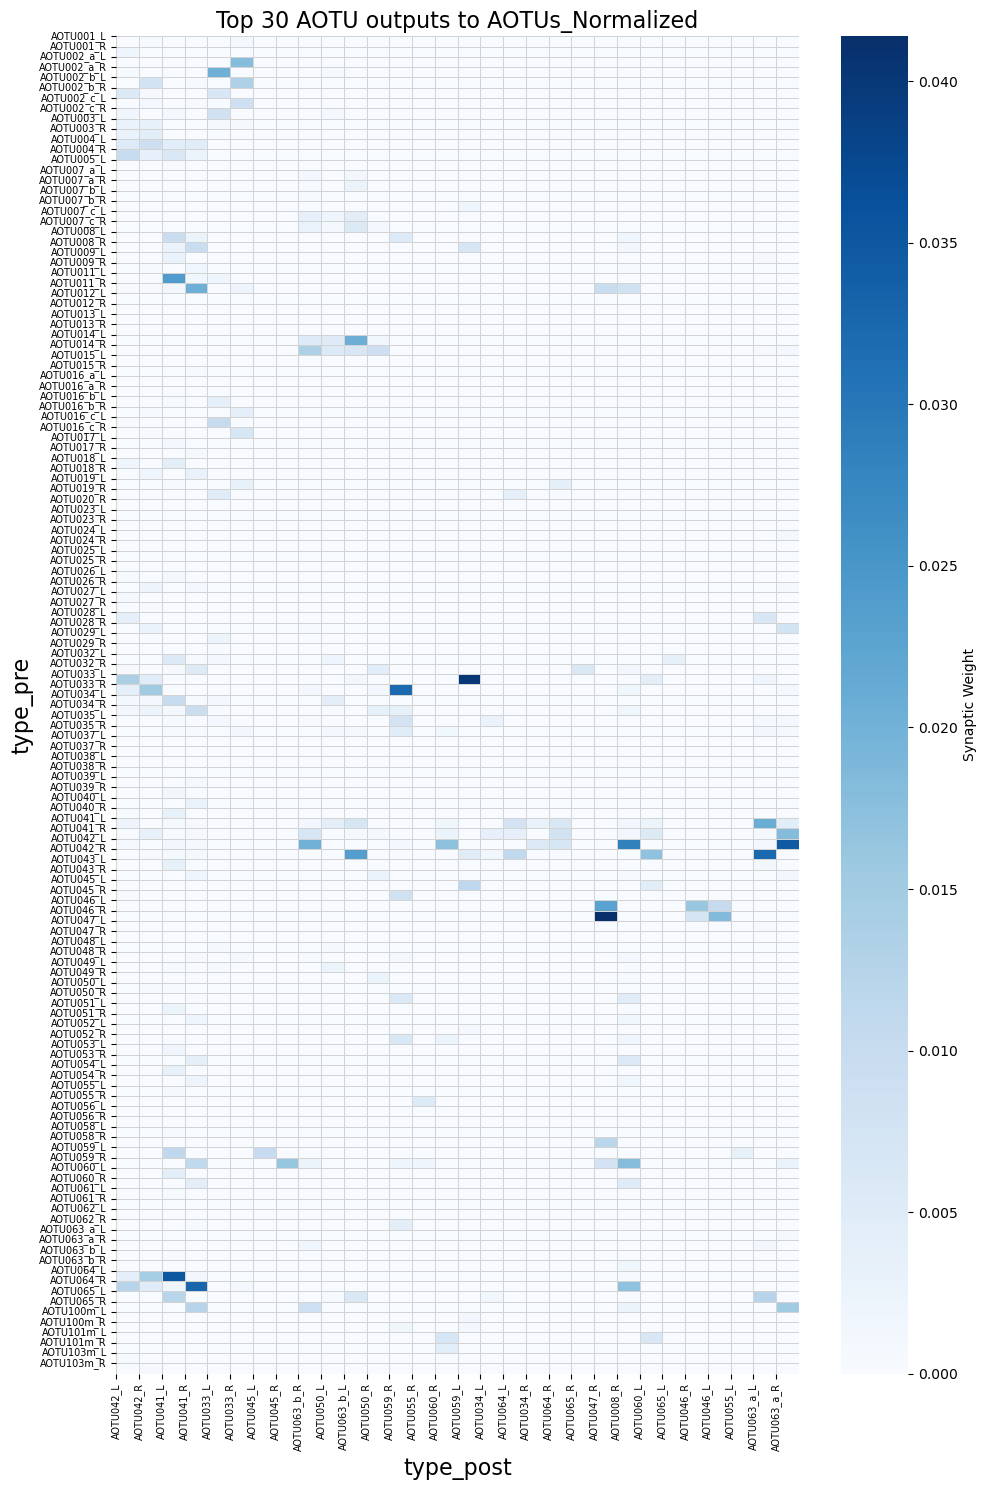

In [42]:
n = 30
# Top 30 posts (columns) by total input received
top_output_instances_norm = norm_matrix_df.sum(axis=1).nlargest(n).index
# Slice matrix: all pre, top 30 post
top_post_matrix_norm = norm_matrix_df.loc[:, top_output_instances_norm]

# Plot
plt.figure(figsize=(10, 15))
ax = sb.heatmap(top_post_matrix_norm, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} AOTU outputs to AOTUs_Normalized', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(top_post_matrix_norm.index)))
ax.set_yticklabels(top_post_matrix_norm.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(top_post_matrix_norm.columns)))
ax.set_xticklabels(top_post_matrix_norm.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save figure
os.makedirs('results', exist_ok=True)
plt.savefig(f'results/AOTU/Normalized synaptic weights_AOTU_AOTU_Top30outputs.png', dpi=600)

plt.show()

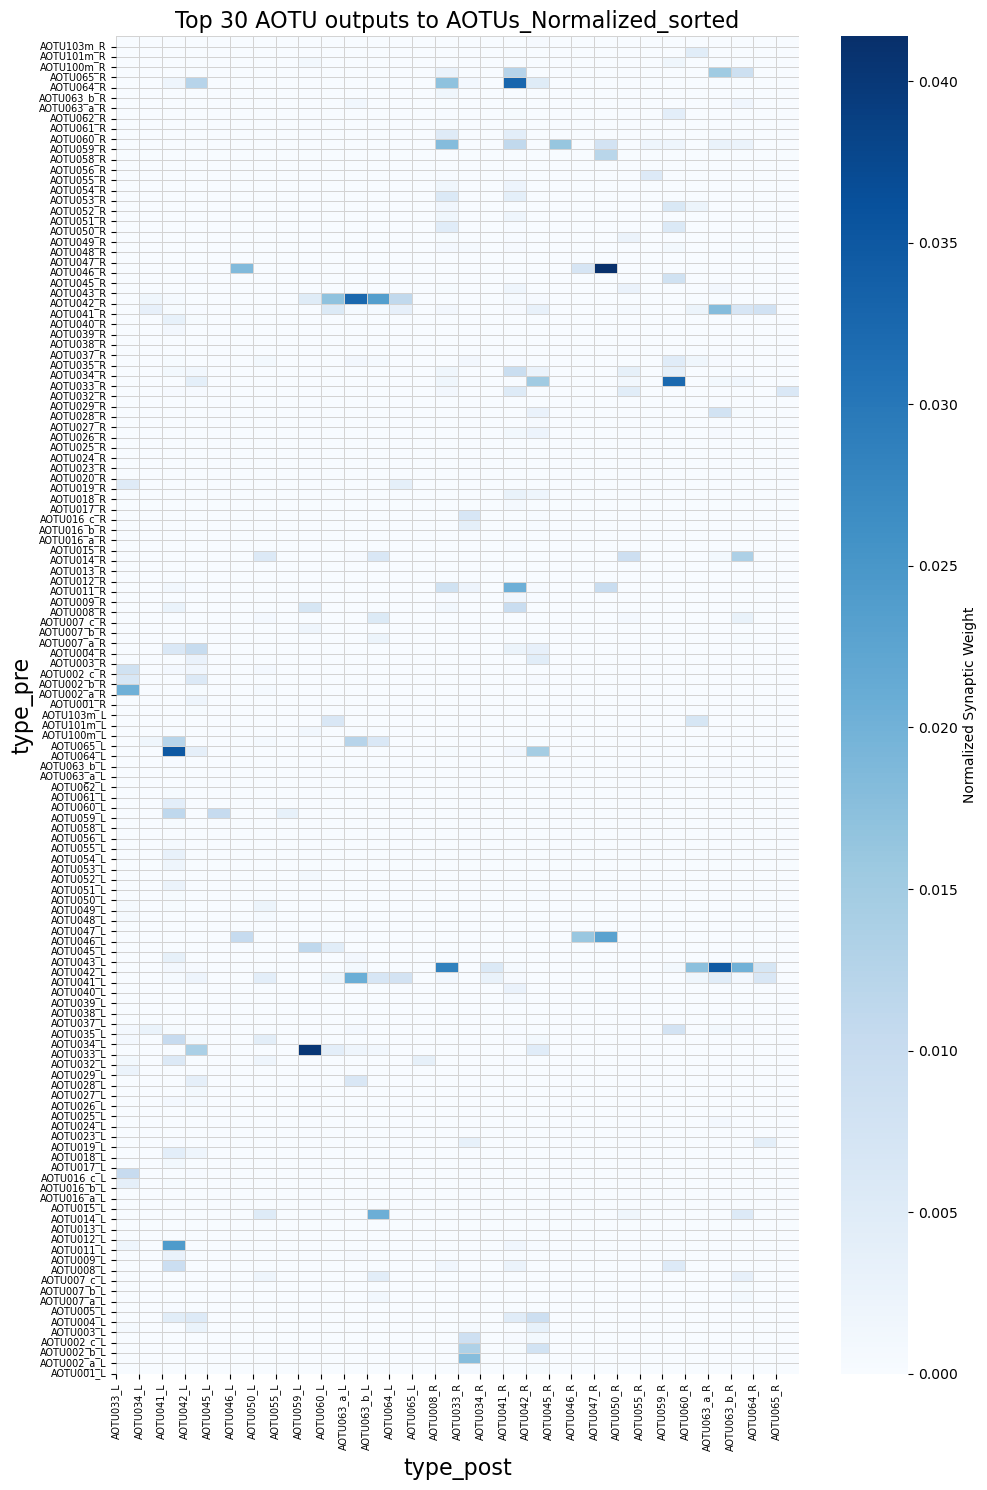

In [44]:
n = 30

# Step 1: Get top N post instances by total normalized input
top_output_instances_norm = norm_matrix_df.sum(axis=1).nlargest(n).index

# Step 2: Slice normalized matrix to include all rows, top N columns
top_post_matrix_norm = norm_matrix_df.loc[:, top_output_instances_norm]

# Step 3: Sorting key (L/R → ID → subtype)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Step 4: Sort both rows and columns
sorted_rows = sorted(top_post_matrix_norm.index, key=sort_key)
sorted_cols = sorted(top_post_matrix_norm.columns, key=sort_key)

# Step 5: Reorder matrix
ordered_top_post_matrix_norm = top_post_matrix_norm.loc[sorted_rows, sorted_cols]

# Step 6: Plot
plt.figure(figsize=(10, 15))
ax = sb.heatmap(ordered_top_post_matrix_norm, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Normalized Synaptic Weight"})

ax.set_title(f'Top {n} AOTU outputs to AOTUs_Normalized_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_post_matrix_norm.index)))
ax.set_yticklabels(ordered_top_post_matrix_norm.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_top_post_matrix_norm.columns)))
ax.set_xticklabels(ordered_top_post_matrix_norm.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save
os.makedirs('results', exist_ok=True)
plt.savefig(f'results/AOTU/Normalized synaptic weights_AOTU_AOTU_Top30outputs_sorted.png', dpi=600)

plt.show()


# Define pre and post cell types for the original weight matrix (ALL)

#### Extract cell types for sub-matrix

In [ ]:
# #  Define pre- and post-synaptic cell types
# celltypes_pre = NC(type = (None)); # shows all 
# celltypes_post = NC(type = (None)); # shows all 

#### Fetch connections

In [ ]:
# #  Set connection weight threshold
# threshold = 5 #minimum 5 synapses

# # Fetch synaptic connectivity between pre and post types
# neu_df, conn_df = fetch_adjacencies(celltypes_pre, celltypes_post, min_roi_weight=threshold)

# # Merge with neuron properties to get types on both sides
# conn_all_df = merge_neuron_properties(neu_df, conn_df)

# # Group by type combinations and sum the weights by type
# conn_all_df_type = conn_all_df.groupby(['type_pre','type_post'])['weight'].sum().reset_index()

# # Visualize
# #conn_all_df_type

  0%|          | 0/888 [00:00<?, ?it/s]

In [ ]:
#filter for only strong connections, if needed
#replace conn_all_df_type with conn_all_df_type_top in the below cell

#conn_all_df_type_top = conn_all_df_type[conn_all_df_type['weight']>50]

In [5]:
# Fetch neurons and get their types
neurons_AOTU_df,roi_AOTU_df = fetch_neurons(NC(type='^AOTU.*'))
neurons_AOTU_df

/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]
/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]


,bodyId,instance,type,pre,post,downstream,upstream,size,status,statusLabel,...,mancGroup,superclass,flywireType,dimorphism,somaNeuromere,mancSerial,exitNerve,rootSide,inputRois,outputRois
0,10005,AOTU019_R,AOTU019,2837,31981,23423,31981,11847745920,Traced,Roughly traced,...,None,cb_intrinsic,AOTU019,None,None,None,None,None,"[AOTU(R), CRE(R), CentralBrain, CentralBrain-u...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
1,10031,AOTU041_R,AOTU041,2134,20586,13446,20586,5326291658,Traced,Roughly traced,...,None,cb_intrinsic,AOTU041,None,None,None,None,None,"[AOTU(L), AOTU(R), CRE(L), CRE(R), CentralBrai...","[AOTU(L), AOTU(R), CentralBrain, CentralBrain-..."
2,10070,AOTU019_L,AOTU019,2836,30714,23596,30714,11809707230,Traced,Roughly traced,...,None,cb_intrinsic,AOTU019,None,None,None,None,None,"[AOTU(L), CRE(L), CentralBrain, CentralBrain-u...","[AOTU(L), CRE(L), CentralBrain, CentralBrain-u..."
3,10148,AOTU041_L,AOTU041,2336,19960,14187,19960,5592462575,Traced,Roughly traced,...,None,cb_intrinsic,AOTU041,None,None,None,None,None,"[AOTU(L), AOTU(R), BU(L), CRE(L), CentralBrain...","[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr..."
4,10212,AOTU042_L,AOTU042,3579,10679,22690,10679,4312493196,Traced,Roughly traced,...,None,cb_intrinsic,AOTU042,None,None,None,None,None,"[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr...","[AOTU(L), AOTU(R), CRE(L), CentralBrain, Centr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,555803,AOTU024_R,AOTU024,814,2240,6989,2240,964400165,Traced,Roughly traced,...,None,cb_intrinsic,AOTU024,None,None,None,None,None,"[AOTU(R), ATL(L), ATL(R), CRE(R), CentralBrain...","[AOTU(R), ATL(L), ATL(R), CentralBrain, Centra..."
308,557095,AOTU008_L,AOTU008,392,2167,3198,2167,832073642,Traced,Roughly traced,...,None,cb_intrinsic,AOTU008,sexually dimorphic,None,None,None,None,"[AOTU(L), AOTU(R), CentralBrain, CentralBrain-...","[AOTU(L), CentralBrain, CentralBrain-unspecifi..."
309,565505,AOTU008_R,AOTU008,315,2727,2802,2727,502528277,Traced,Roughly traced,...,None,cb_intrinsic,AOTU008,sexually dimorphic,None,None,None,None,"[AOTU(R), CentralBrain, CentralBrain-unspecifi...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."
310,902249,AOTU038_R,AOTU038,111,459,704,459,278656951,Traced,Roughly traced,...,None,cb_intrinsic,CB3984,None,None,None,None,None,"[AOTU(R), AVLP(R), CentralBrain, CentralBrain-...","[AOTU(R), CentralBrain, CentralBrain-unspecifi..."


In [6]:
AOTU_celltypes = neurons_AOTU_df['type'].unique()
AOTU_celltypes

array(['AOTU019', 'AOTU041', 'AOTU042', 'AOTU023', 'AOTU012', 'AOTU035',
       'AOTU005', 'AOTU100m', 'AOTU016_c', 'AOTU061', 'AOTU052',
       'AOTU103m', 'AOTU063_b', 'AOTU064', 'AOTU033', 'AOTU101m',
       'AOTU063_a', 'AOTU049', 'AOTU027', 'AOTU014', 'AOTU015', 'AOTU046',
       'AOTU050', 'AOTU024', 'AOTU059', 'AOTU009', 'AOTU008', 'AOTU045',
       'AOTU065', 'AOTU007_c', 'AOTU002_c', 'AOTU029', 'AOTU016_a',
       'AOTU002_a', 'AOTU026', 'AOTU020', 'AOTU017', 'AOTU028',
       'AOTU016_b', 'AOTU036', 'AOTU006', 'AOTU043', 'AOTU048', 'AOTU013',
       'AOTU051', 'AOTU034', 'AOTU011', 'AOTU002_b', 'AOTU022', 'AOTU062',
       'AOTU032', 'AOTU001', 'AOTU007_b', 'AOTU047', 'AOTU003',
       'AOTU007_a', 'AOTU054', 'AOTU053', 'AOTU030', 'AOTU056', 'AOTU055',
       'AOTU060', 'AOTU102m', 'AOTU038', 'AOTU058', 'AOTU037', 'AOTU018',
       'AOTU004', 'AOTU039', 'AOTU040', 'AOTU021', 'AOTU025'],
      dtype=object)

In [8]:
# # Define input and output cell type groups
cell_type1 = AOTU_celltypes  # pre
cell_type2 = AOTU_celltypes    # post

#### Filter the matrix based on pre and post cell types, create a sub_matrix

In [9]:
# Extract raw weight submatrix: AOTU (pre) → DN (post)
sub_matrix = matrix_df.loc[matrix_df.index.isin(cell_type1), matrix_df.columns.isin(cell_type2)]

# Extract normalized submatrix: AOTU (pre) → DN (post)
norm_sub_matrix = norm_matrix_df.loc[norm_matrix_df.index.isin(cell_type1), norm_matrix_df.columns.isin(cell_type2)]

#### Plot raw weights

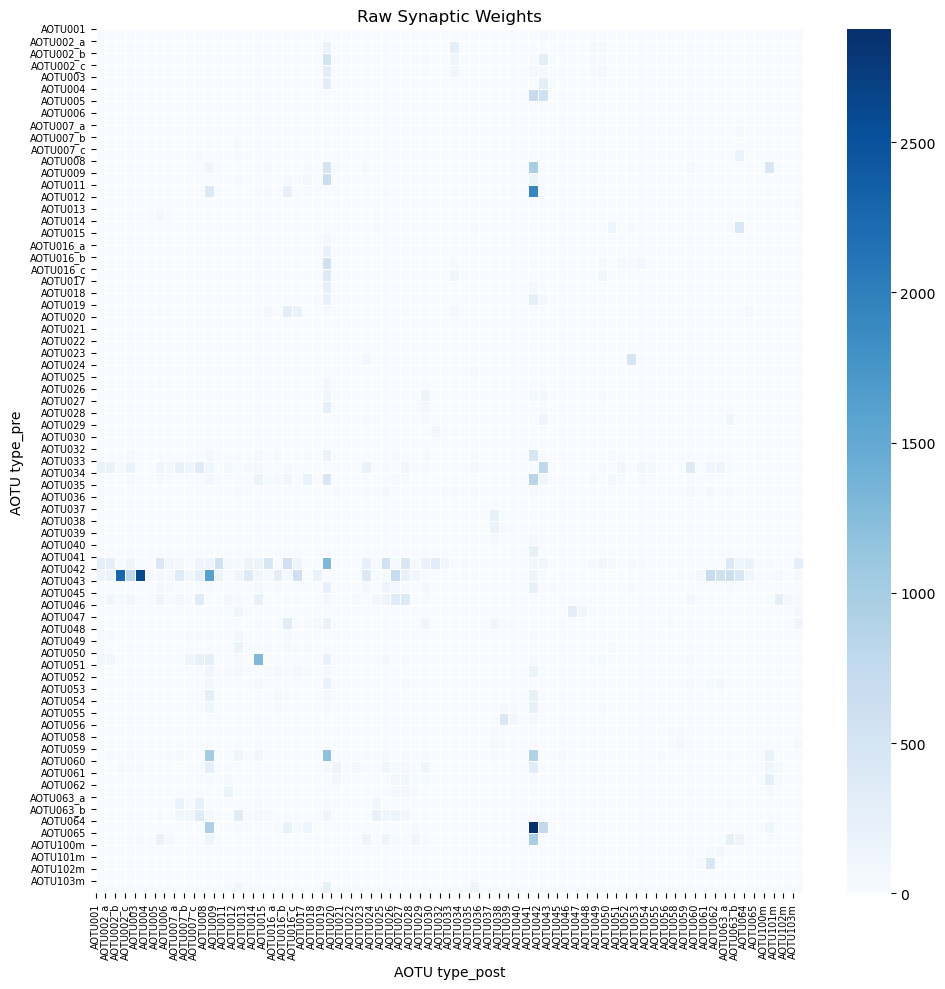

In [11]:
plt.figure(figsize=(10, 10))
ax = sb.heatmap(sub_matrix, cmap='Blues', annot=False, linewidths=0.5)

ax.set_title('Raw Synaptic Weights')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(sub_matrix.index)))
ax.set_yticklabels(sub_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(sub_matrix.columns)))
ax.set_xticklabels(sub_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Raw synaptic weights_AOTUpre_AOTUpost_all.png', dpi=300)

plt.show()

#### Plot top input connections_Raw

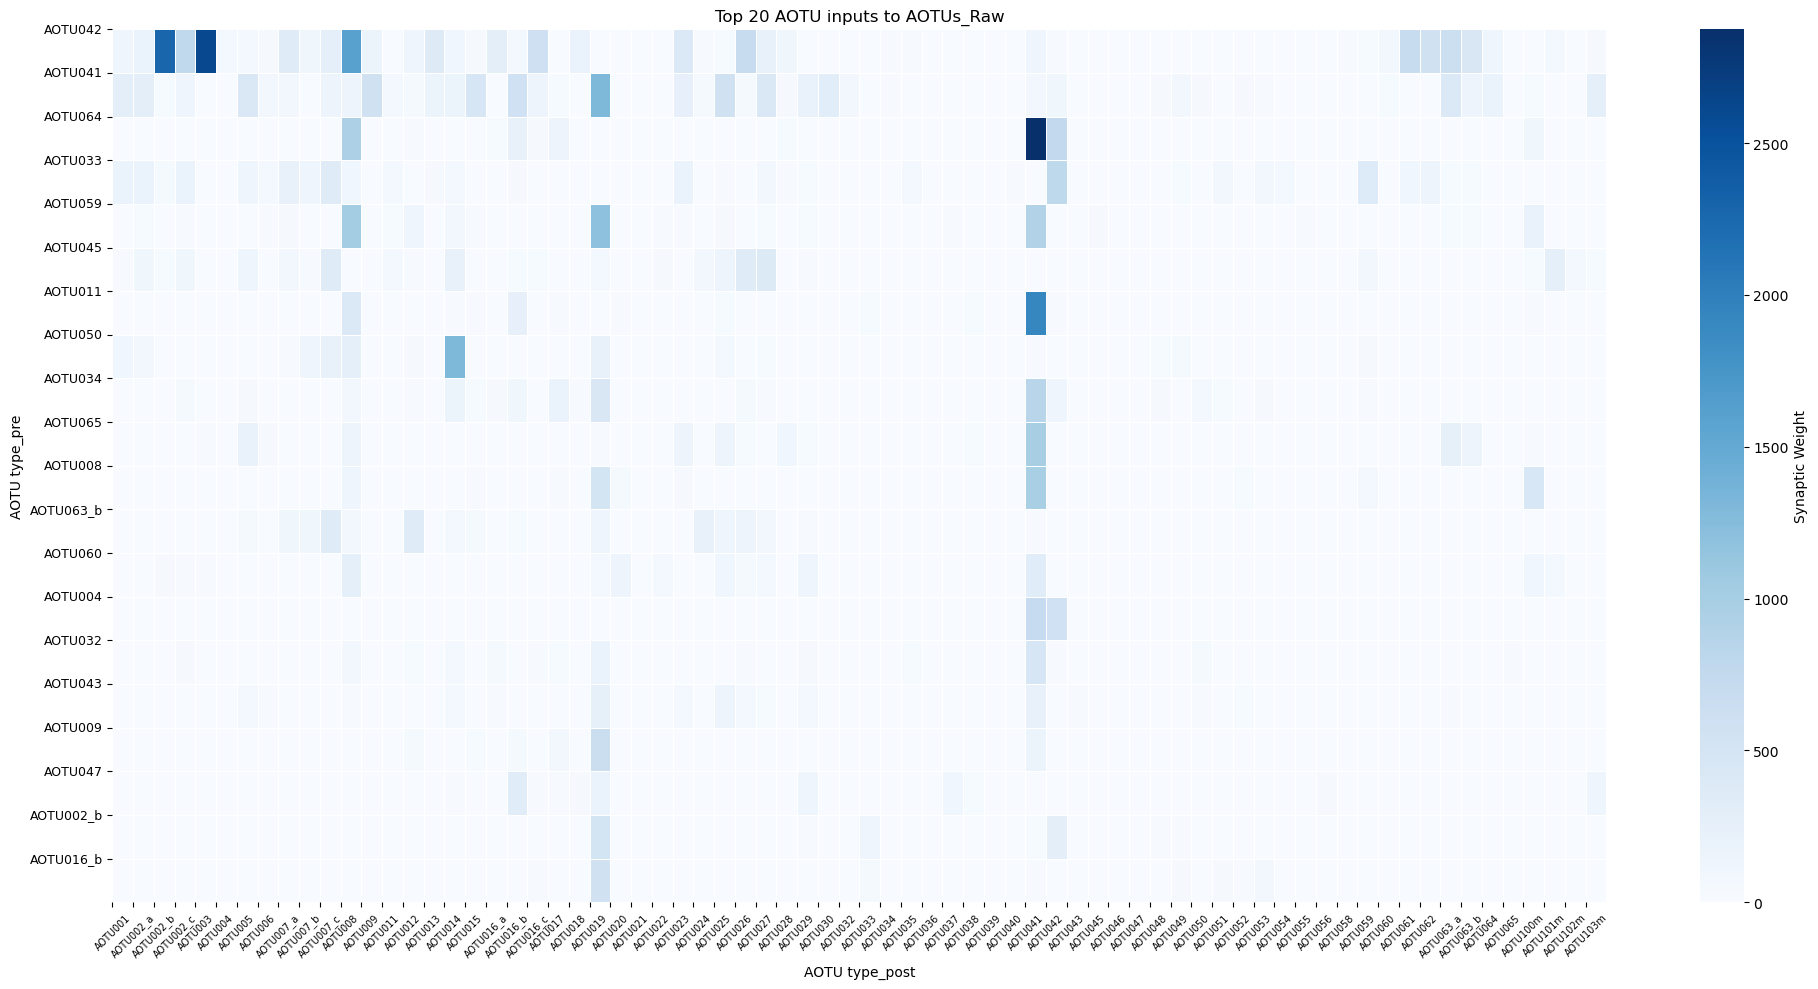

In [12]:
n = 20

# Find top n AOTU types by total outgoing weight to DNs
top_inputs_raw = sub_matrix.sum(axis=1).nlargest(n).index

# Slice submatrix for these AOTU pre types
top_input_matrix = sub_matrix.loc[top_inputs_raw]

# Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(top_input_matrix, cmap='Blues', annot=False, linewidths=0.5,
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} AOTU inputs to AOTUs_Raw')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_input_matrix.index)))
ax.set_yticklabels(top_input_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_matrix.columns)))
ax.set_xticklabels(top_input_matrix.columns, rotation=45, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Raw synaptic weights_AOTUpre_DNpost_Top20_AOTUinputs.png', dpi=300)

plt.show()

#### Plot top output connections

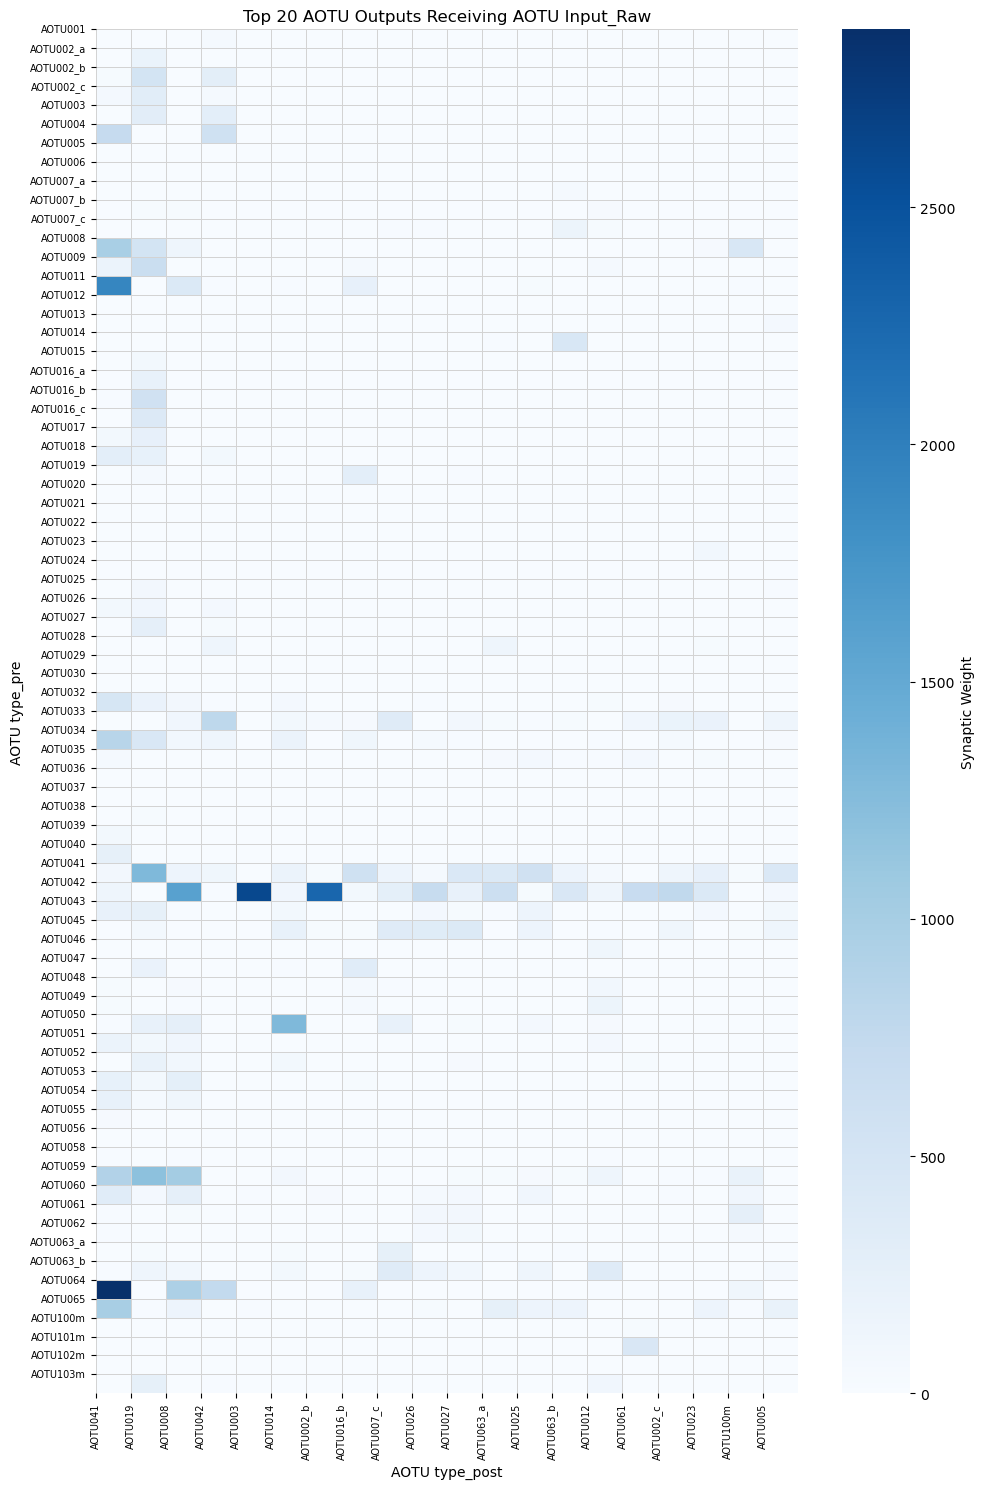

In [13]:
# Adjust how many top DN outputs to display
n = 20

# Get DN types with highest total input from AOTUs
top_outputs_raw = sub_matrix.sum(axis=0).nlargest(n).index

# Slice the matrix to include only those DN columns
top_output_matrix = sub_matrix.loc[:, top_outputs_raw]

# Plot
plt.figure(figsize=(10, 15))
ax = sb.heatmap(top_output_matrix, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} AOTU Outputs Receiving AOTU Input_Raw')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_output_matrix.index)))
ax.set_yticklabels(top_output_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(top_output_matrix.columns)))
ax.set_xticklabels(top_output_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Raw synaptic weights_AOTUpre_DNpost_Top20DNoutputs.png', dpi=300)

plt.show()


#### Top inputs and outputs both

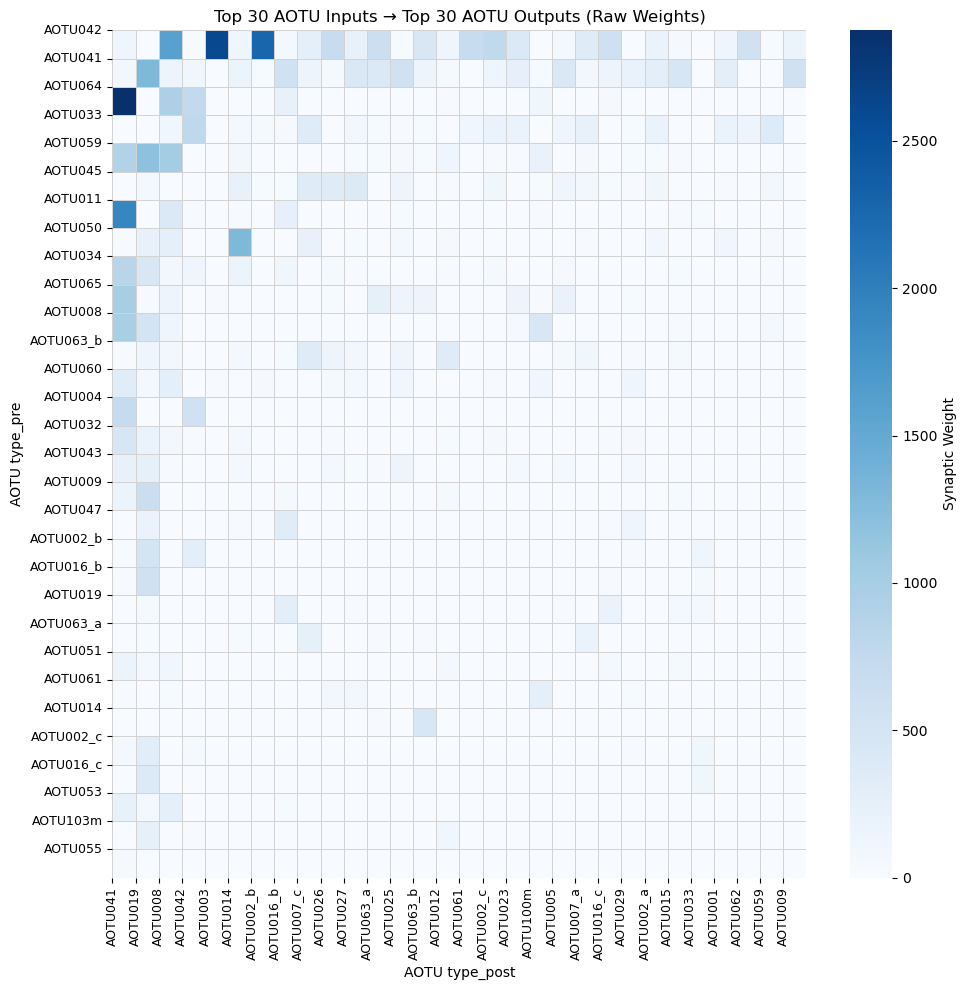

In [18]:
# Parameters
n = 30  # Top AOTU input types
m = 30  # Top DN output types

# Get top N AOTU input types by total outgoing weight
topn_inputs_raw = sub_matrix.sum(axis=1).nlargest(n).index

# Get top M DN output types by total incoming weight
topm_outputs_raw = sub_matrix.sum(axis=0).nlargest(m).index

# Slice matrix using both top inputs and top outputs
top_input_output_matrix = sub_matrix.loc[topn_inputs_raw, topm_outputs_raw]

# Plot
plt.figure(figsize=(10, 10))
ax = sb.heatmap(
    top_input_output_matrix,
    cmap='Blues',
    annot=False,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={"label": "Synaptic Weight"}
)

ax.set_title(f'Top {n} AOTU Inputs → Top {m} AOTU Outputs (Raw Weights)')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_input_output_matrix.index)))
ax.set_yticklabels(top_input_output_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_output_matrix.columns)))
ax.set_xticklabels(top_input_output_matrix.columns, rotation=90, fontsize=9)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Raw synaptic weights_AOTUpre_AOTUpost_Top30AOTUinputss_Top30AOTUoutputs.png', dpi=300)

plt.show()


#### Plot normalized weights

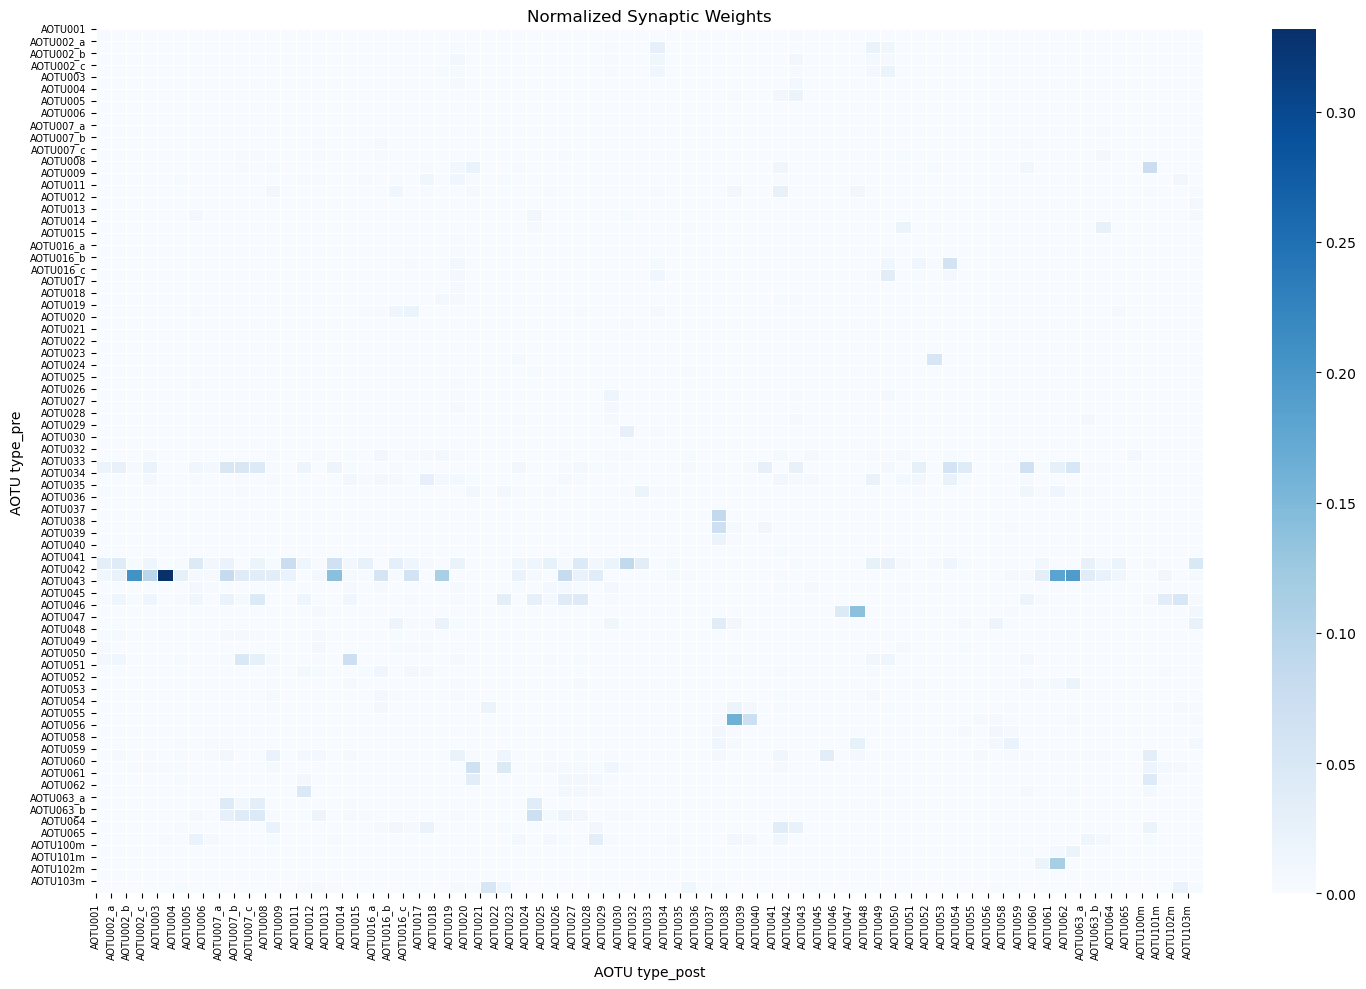

In [19]:
plt.figure(figsize=(15, 10))
ax = sb.heatmap(norm_sub_matrix, cmap='Blues', annot=False, linewidths=0.5)

ax.set_title('Normalized Synaptic Weights')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(norm_sub_matrix.index)))
ax.set_yticklabels(norm_sub_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(norm_sub_matrix.columns)))
ax.set_xticklabels(norm_sub_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Norm synaptic weights_AOTUpre_AOTUpost_all.png', dpi=300)

plt.show()

#### Plot top input connections_Normalized

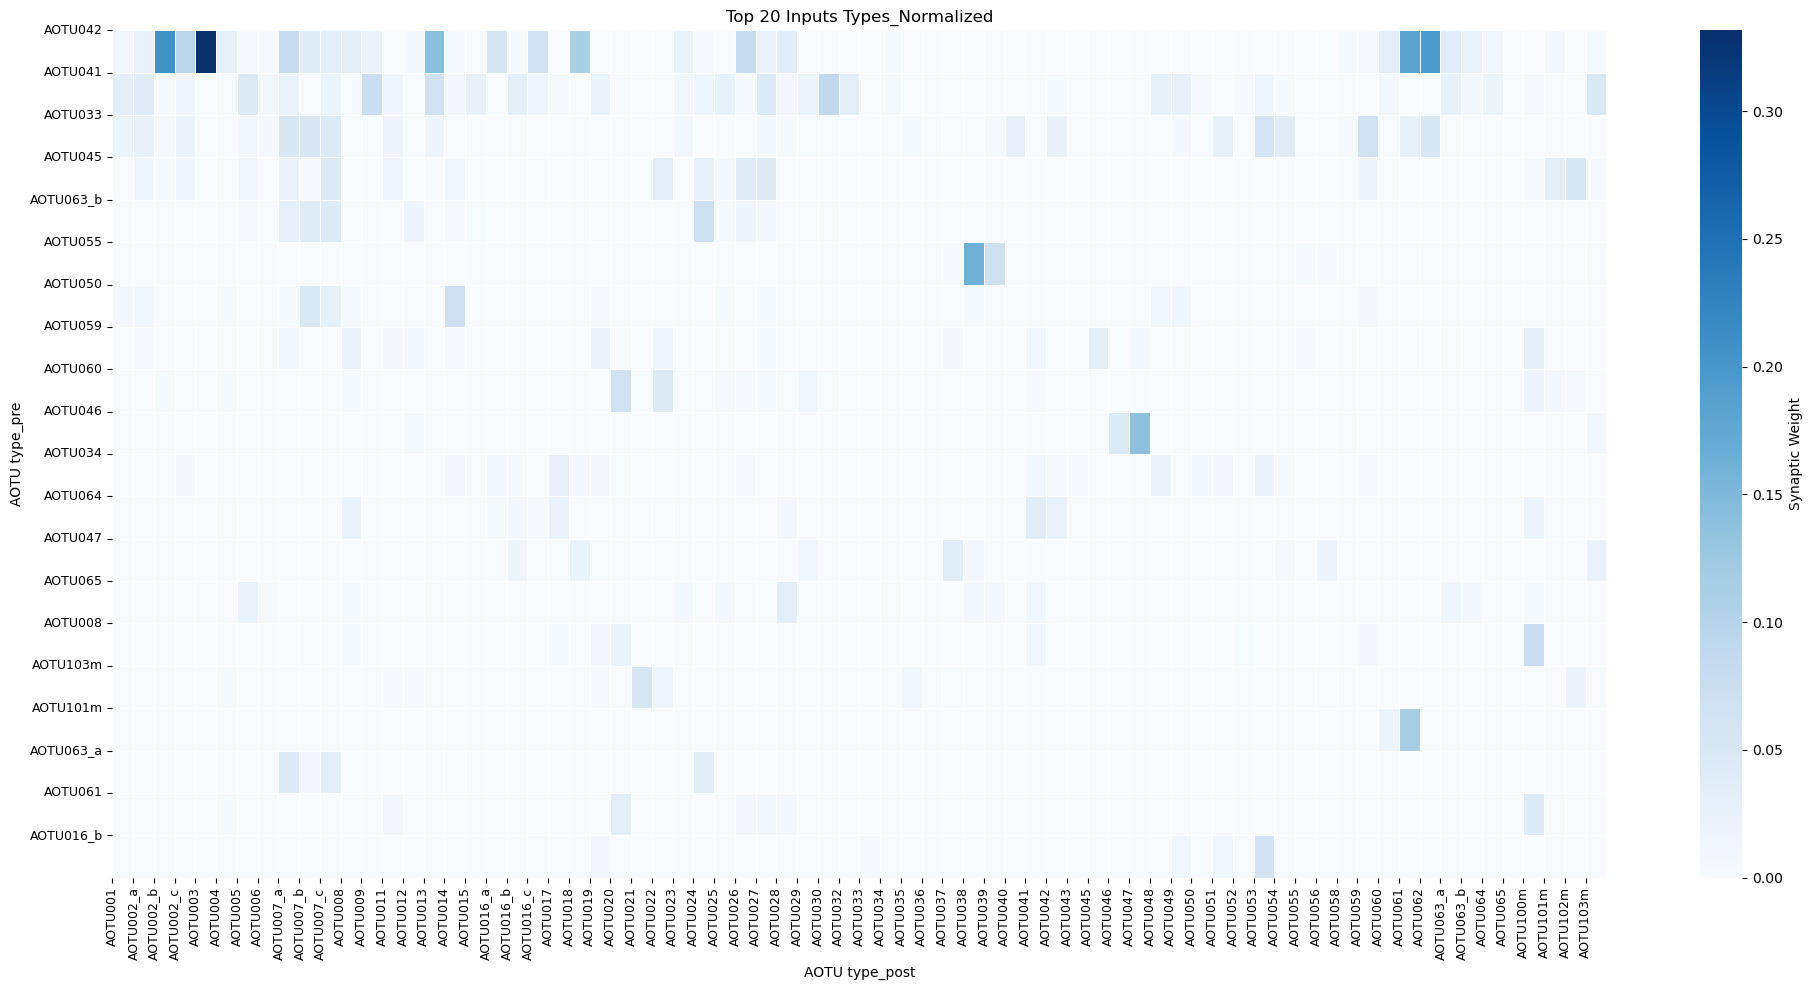

In [21]:
n = 20

# Find top n AOTU types by total outgoing weight to DNs
top_inputs_norm = norm_sub_matrix.sum(axis=1).nlargest(n).index

# Slice submatrix for these AOTU pre types
top_input_matrix_norm = norm_sub_matrix.loc[top_inputs_norm]

# Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(top_input_matrix_norm, cmap='Blues', annot=False, linewidths=0.5, 
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} Inputs Types_Normalized')
ax.set_xlabel('AOTU type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_input_matrix_norm.index)))
ax.set_yticklabels(top_input_matrix_norm.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_matrix_norm.columns)))
ax.set_xticklabels(top_input_matrix_norm.columns, rotation=90, fontsize=9)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Norm synaptic weights_AOTUpre_AOTUpost_Top20_AOTUinputs.png', dpi=300)

plt.show()

#### Plot top outputs_Normalized

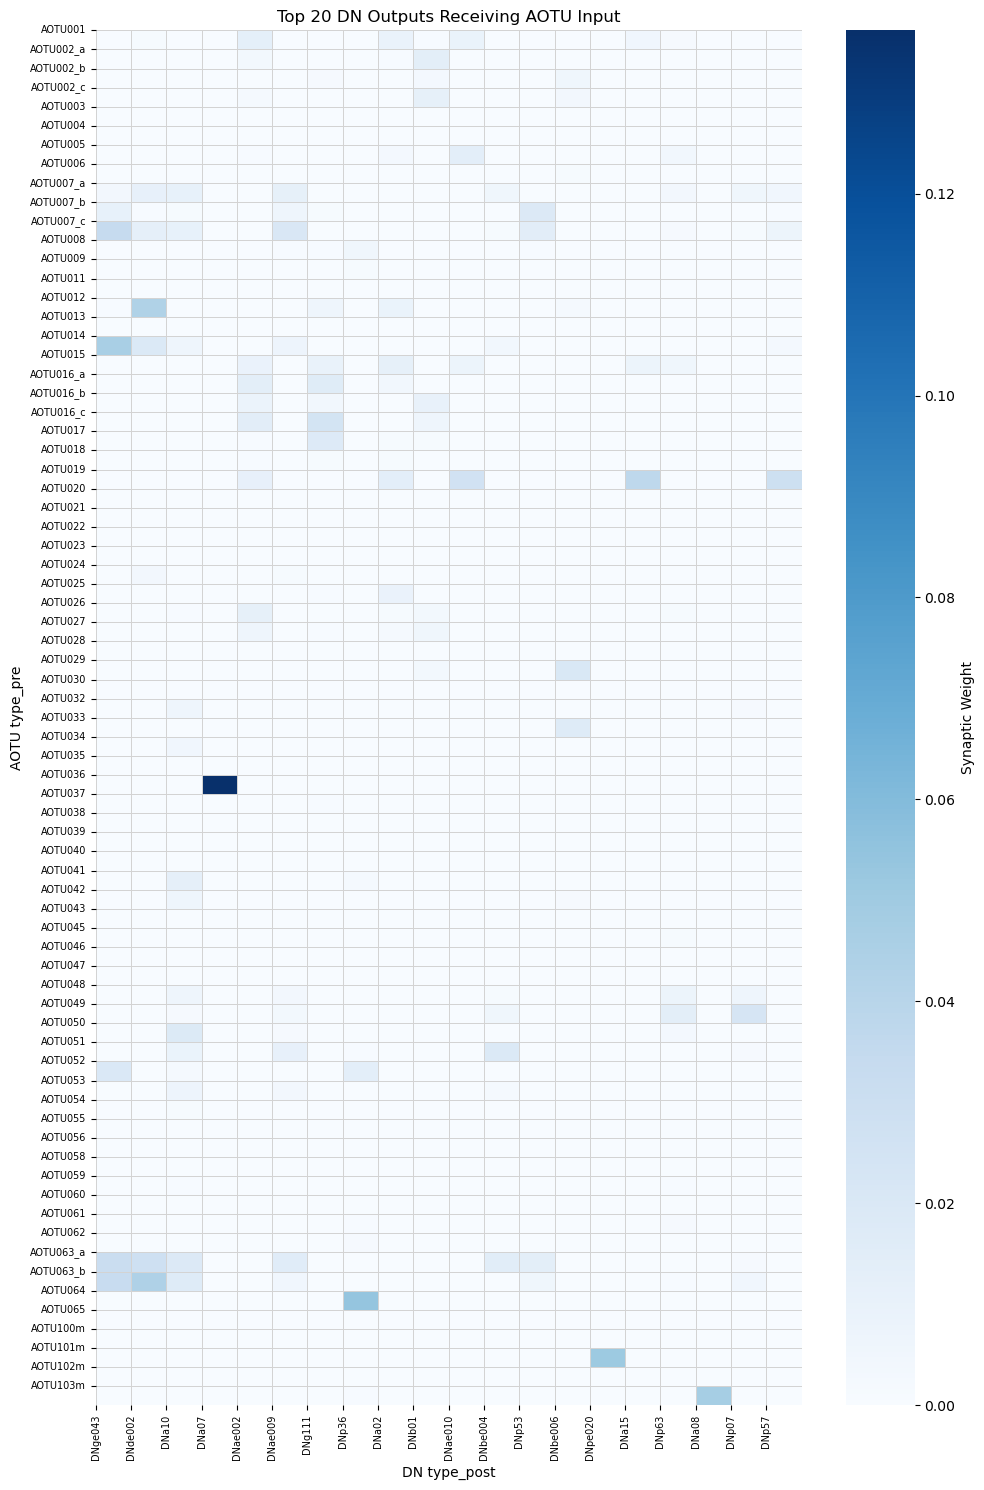

In [ ]:
# Adjust how many top DN outputs to display
n = 20

# Get DN types with highest total input from AOTUs
top_outputs_norm = norm_sub_matrix.sum(axis=0).nlargest(n).index

# Slice the matrix to include only those DN columns
top_output_matrix_norm = norm_sub_matrix.loc[:, top_outputs_norm]

# Plot
plt.figure(figsize=(10, 15))
ax = sb.heatmap(top_output_matrix_norm, cmap='Blues', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} DN Outputs Receiving AOTU Input')
ax.set_xlabel('DN type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_output_matrix_norm.index)))
ax.set_yticklabels(top_output_matrix_norm.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(top_output_matrix_norm.columns)))
ax.set_xticklabels(top_output_matrix_norm.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Norm synaptic weights_AOTUpre_DNpost_Top20_DNoutputs.png', dpi=300)

plt.show()

#### Top inputs and outputs_normalized

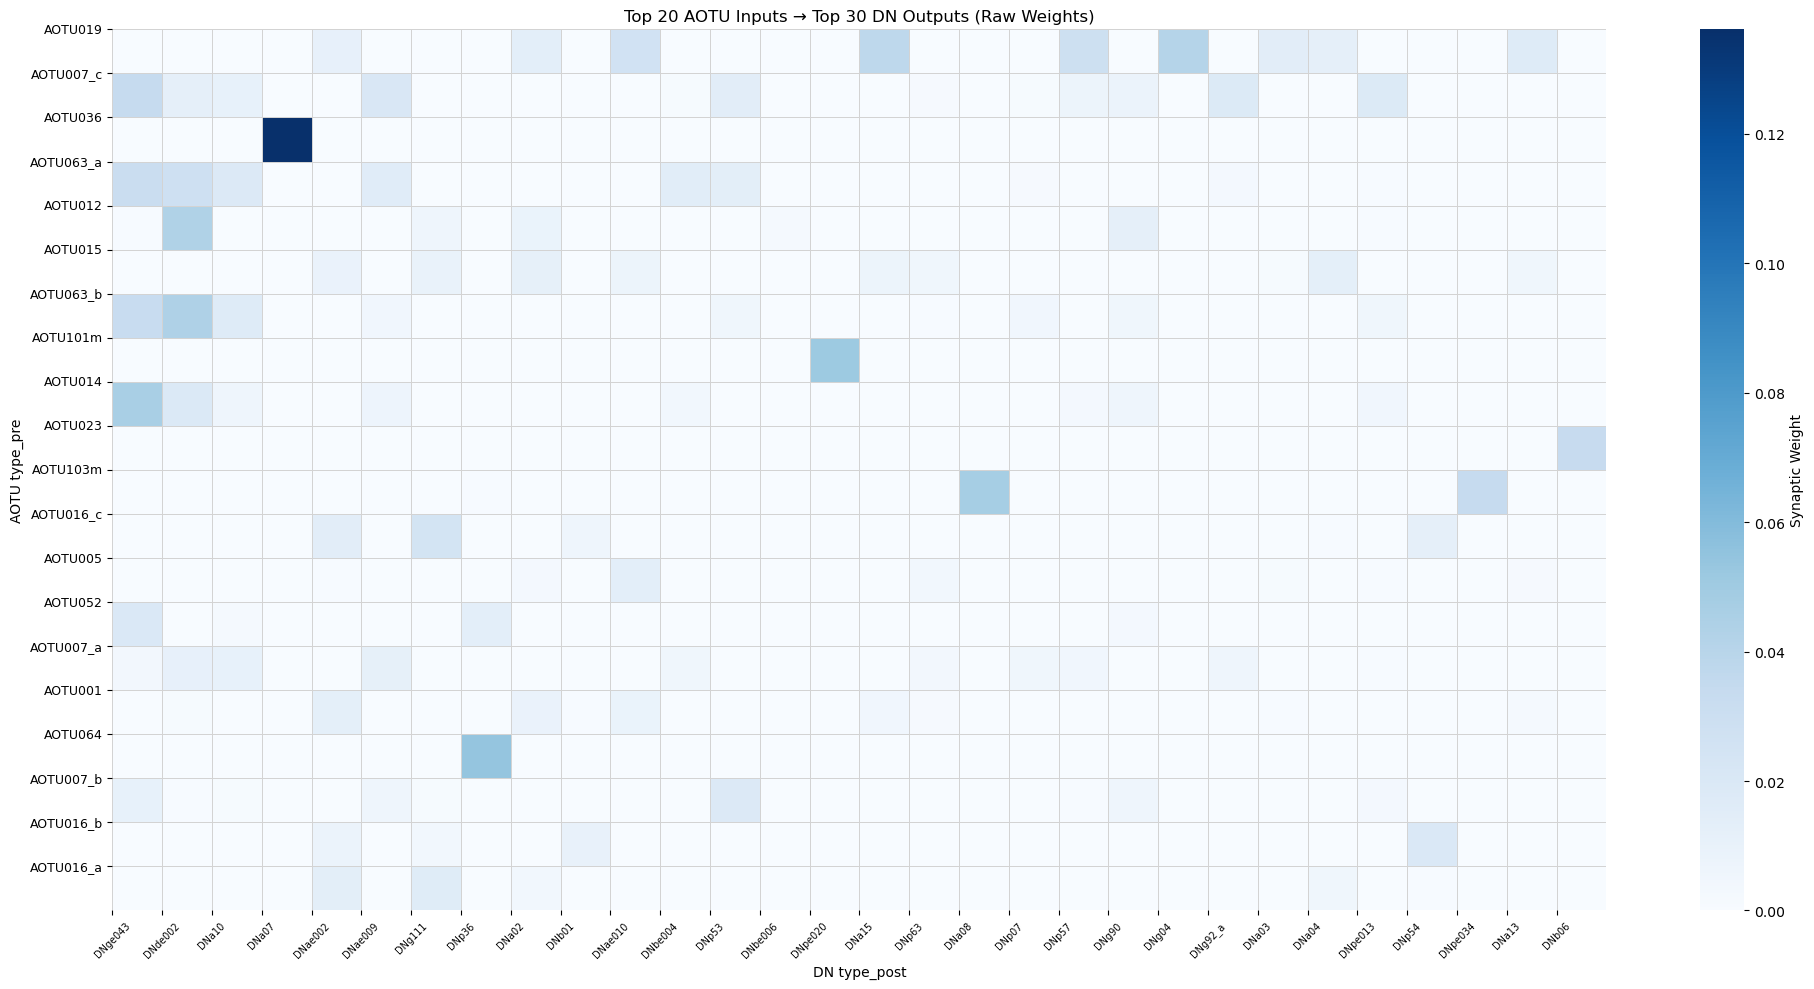

In [ ]:
# Parameters
n = 20  # Top AOTU input types
m = 30  # Top DN output types

# Get top N AOTU input types by total outgoing weight
topn_inputs_norm = norm_sub_matrix.sum(axis=1).nlargest(n).index

# Get top M DN output types by total incoming weight
topm_outputs_norm = norm_sub_matrix.sum(axis=0).nlargest(m).index

# Slice matrix using both top inputs and top outputs
top_input_output_matrix = norm_sub_matrix.loc[topn_inputs_norm, topm_outputs_norm]

# Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(
    top_input_output_matrix,
    cmap='Blues',
    annot=False,
    linewidths=0.5,
    linecolor='lightgray',
    cbar_kws={"label": "Synaptic Weight"}
)

ax.set_title(f'Top {n} AOTU Inputs → Top {m} DN Outputs (Raw Weights)')
ax.set_xlabel('DN type_post')
ax.set_ylabel('AOTU type_pre')

ax.set_yticks(range(len(top_input_output_matrix.index)))
ax.set_yticklabels(top_input_output_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_output_matrix.columns)))
ax.set_xticklabels(top_input_output_matrix.columns, rotation=45, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/Norm synaptic weights_AOTUpre_DNpost_Top20AOTUinputs_Top30_DNoutputs.png', dpi=300)

plt.show()